In [1]:
# python -m notebook --ip=0.0.0.0 --no-browser --NotebookApp.allow_origin='*' --NotebookApp.token='' --NotebookApp.password=''
# ssh  mac9908@sporcsubmit.rc.rit.edu -L 8888:clx-a-01.rc.rit.edu:8888
import datasets
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
palette = {'CLARA':"#9b59b6", 'FA(L)':"#3498db", 'FA(L+E)':"#95a5a6"}
# spack load py-pip/ylgeevx
class ClaraAnalysis():
  def __init__(self) -> None:
     self.dataset_dir = 'dataset'
     self.techniques = {0: 'CLARA', 1: 'FA(L)', 3: 'FA(L+E)'}
     self.dataset = datasets.load_from_disk(self.dataset_dir)
     self.dataset = self.dataset.map(self.assign_technique)
     self.dataset = self.dataset.map(self.parse_error_output)
     self.dataframe = self.dataset['final'].to_pandas()
     
     # Setting proper types of data  
     self.dataframe['Technique'] = pd.Categorical(self.dataframe['Technique'])
     self.dataframe['Percentage Repaired'] = self.dataframe['Percentage Repaired'].astype(float)

  def parse_error_output(self, x):
    if x['Parse Error'] == 'True':
        return {'Parse Error Output': re.findall(r':([^\(]+)', x['Error Output'].split('\n')[-2])[0]}
    else:
        return {'Parse Error Output': None}
  def assign_technique(self, x):
    x['Technique'] = self.techniques[x['Technique']]
    return x
  def group_analyze(self, column, type=None, filter=None):
    if type is not None:
      self.dataframe[column] = self.dataframe[column].astype(type)
    return self.dataframe.groupby([column])[column].count()
  
  def summary_statistic(self):
    pass
      
  def groups_analyze(self, columns, df=None):
    if df is None:
      df = self.dataframe
    return df.groupby(columns)[columns].count()

#   def parse_error_output(self, x):
#     return {'Parse Error Output': re.findall(r':([^\(]+)', x['Error Output'].split('\n')[-2])[0]}

  def filter_group_analyze(self, column, type=None):
    dt_parse_error = self.dataset.filter(lambda x: x['Parse Error'] == 'True')\
      .map(self.parse_error_output)
    print(self.group_analyze(dt_parse_error['final'].to_pandas(), 'Parse Error Output', type="category"))
  
  def draw_boxplot(self, groups, title='Title', ylabel='YLabel'):
    data = [self.dataframe[grp].astype(float).to_numpy() for grp in groups]
    sns.boxplot(data)

In [2]:
clara = ClaraAnalysis()

Loading cached processed dataset at /home/mac9908/clara/problems/dataset/final/cache-ce9ebe70298a7f9f.arrow
Loading cached processed dataset at /home/mac9908/clara/problems/dataset/final/cache-1a5318154efcb8ac.arrow


clara.dataframe.head()

In [3]:
# Problem Descriptions
clara.dataframe.columns

Index(['Problem', 'First Output', 'Error Output', 'Correct File',
       'Incorrect File', 'Test Available', 'Correct Locs', 'Incorrect Locs',
       'Old Incorrect Locs', 'Correct Exprs', 'Incorrect Exprs',
       'Old Incorrect Exprs', 'Repairs', 'Technique', 'GM Score', 'Locs',
       'Count', 'Structure Mismatch', 'Repair', 'Repair Correct',
       'Parse Error', 'Cost', 'Second Output', 'Match', 'Percentage Repaired',
       'Timeout', 'Parse Error Output'],
      dtype='object')

In [4]:
# Only keep row, if all techniques have the same correct and incorrect file combo
df = clara.dataframe
display(df.groupby(['Technique', 'Test Available'])['Technique'].count())
df = df[df['Test Available'].isna()!=True]
display(df[df['Technique']=='CLARA'].groupby(['Parse Error Output'])['Technique'].count())
df = df[df['Parse Error'] != 'True']
df = df[df['Test Available'] == 'Yes']
timeout = df[df['Timeout']==True]
display(timeout.groupby(['Technique'])['Technique'].count())
df = df[df['Timeout'] !=True]
df['ci'] = df['Correct File'] + '_' + df['Incorrect File']
grouped = df.groupby('ci')
filtered = grouped.filter(lambda x: x['Technique'].count() == 3)

Technique  Test Available
CLARA      No                25396
           Yes               66327
FA(L)      No                25396
           Yes               58961
FA(L+E)    No                25396
           Yes               57070
Name: Technique, dtype: int64

Parse Error Output
 'Import' object has no attribute 'name'                                           534
 'Subscript' object has no attribute 'id'                                           32
 Assignments to Attribute not supported                                           4244
 Assignments to List not supported                                                 351
 Call of Call not supported                                                         11
 Call of Subscript not supported                                                     5
 Call to Attribute                                                                 237
 Comprehension: not a list of names                                                  6
 Delete target: <class 'clara.model.Var'>                                           11
 For loop with List as target                                                        7
 For-Else not supported                                                           1979
 Multiple delete targets

Technique
CLARA       28
FA(L)      291
FA(L+E)    438
Name: Technique, dtype: int64

In [5]:
# The total distribution of inital program permutations
display(filtered.groupby(['Technique'])['Technique'].count())
# The total distribution of non NaN program permutations
# filtered = filtered[filtered['Test Available'].isna()!=True]
display(len(filtered))
display(filtered.groupby(['Technique'])['Technique'].count())

Technique
CLARA      15688
FA(L)      15688
FA(L+E)    15688
Name: Technique, dtype: int64

47064

Technique
CLARA      15688
FA(L)      15688
FA(L+E)    15688
Name: Technique, dtype: int64

In [6]:
clara.groups_analyze(df=filtered, columns=['Technique', 'Parse Error'])

,,Technique,Parse Error
Technique,Parse Error,,
CLARA,False,15688,15688
FA(L),False,15688,15688
FA(L+E),False,15688,15688


In [7]:
clara.groups_analyze(df=filtered, columns=['Parse Error Output'])

,Parse Error Output
Parse Error Output,


In [8]:
# filtered = filtered[filtered['Parse Error'] != 'True']
clara.groups_analyze(df=filtered, columns=['Technique', 'Test Available'])

,,Technique,Test Available
Technique,Test Available,,
CLARA,Yes,15688,15688
FA(L),Yes,15688,15688
FA(L+E),Yes,15688,15688


In [9]:
# filtered = filtered[filtered['Test Available'] == 'Yes']
clara.groups_analyze(df=filtered, columns=['Timeout'])

,Timeout
Timeout,
False,47064


In [10]:
# filtered = filtered[filtered['Timeout'] !=True]

In [11]:
len(filtered)

47064

In [12]:
filtered.groupby(['Technique'])['Technique'].count()

Technique
CLARA      15688
FA(L)      15688
FA(L+E)    15688
Name: Technique, dtype: int64

In [13]:
clara.groups_analyze(df=filtered, columns=['Technique', 'Structure Mismatch'])

Technique  Structure Mismatch
Technique Structure Mismatch                               
CLARA     False                    1235                1235
          True                    14453               14453
FA(L)     False                   15688               15688
          True                        0                   0
FA(L+E)   False                   15688               15688
          True                        0                   0

In [14]:
filtered['Percentage Repaired'].astype(float).describe()

count    15132.000000
mean        24.652465
std         14.347534
min          1.562500
25%         13.793103
50%         22.222222
75%         32.432432
max        100.000000
Name: Percentage Repaired, dtype: float64

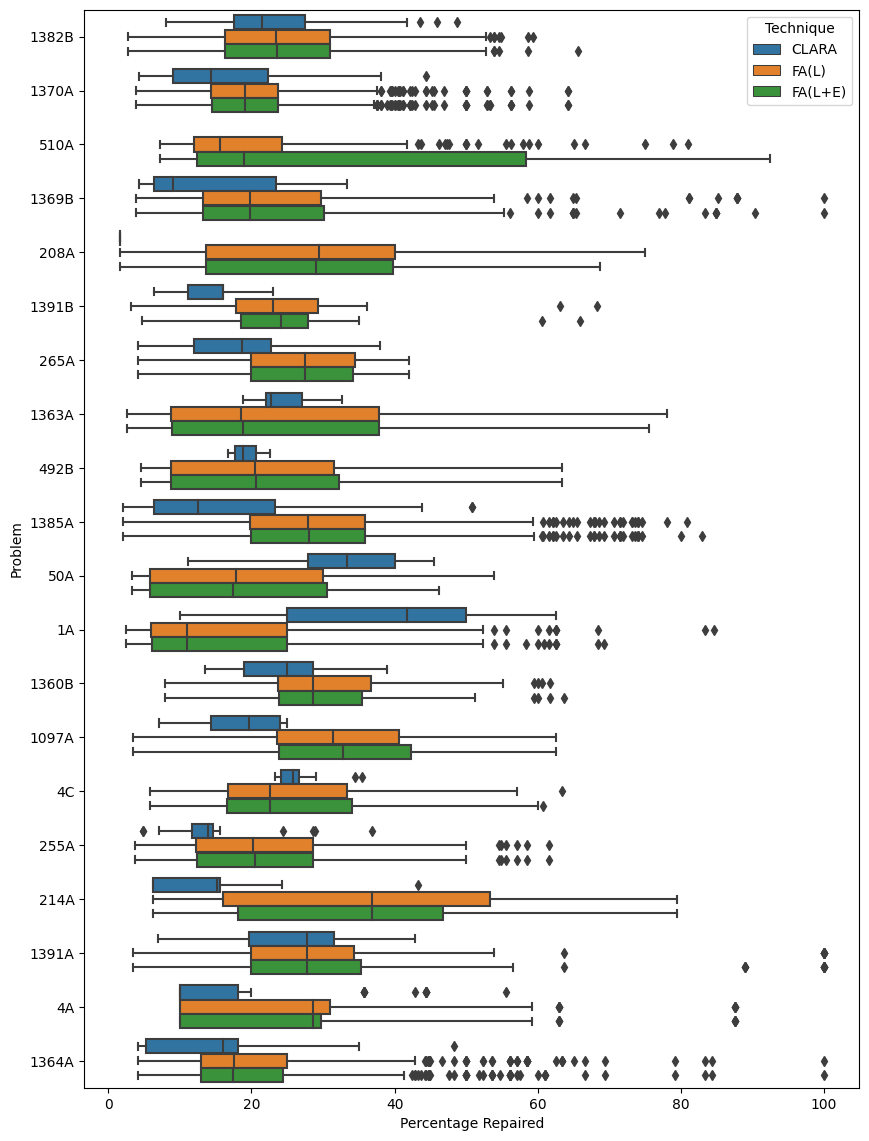

In [15]:
fig = plt.figure(figsize =(10, 14))

ax = sns.boxplot(
    data=filtered, 
    x="Percentage Repaired", 
    hue='Technique', 
    y="Problem",
    orient="h")
# ax.set_title("Percentage Repaired")
ax.set_ylabel("Problem")
ax.set_xlabel("Percentage Repaired")
plt.show()
# plt.savefig("problems_percentage_repaired.png", format='png')

/tmp/ipykernel_11745/236553920.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  filtered.groupby('Problem')['Correct File', 'Incorrect File'].describe()


,count,mean,std,min,25%,50%,75%,max
Difficulty,,,,,,,,
800,8356.0,10.823600,9.242475,2.0,5.0,7.0,15.0,72.0
900,190.0,8.642105,10.993905,2.0,2.0,2.0,12.0,35.0
1000,596.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
1100,889.0,15.452193,4.304593,13.0,13.0,13.0,13.0,23.0
1200,4721.0,11.405423,8.622448,4.0,5.0,8.0,17.0,44.0
1300,380.0,10.302632,1.573358,1.0,10.0,10.0,10.0,13.0


,count,mean,std,min,25%,50%,75%,max
Difficulty,,,,,,,,
800,8356.0,13.522020,8.243329,1.0,8.0,12.0,19.0,65.0
900,190.0,8.442105,10.162402,2.0,2.0,2.0,13.0,32.0
1000,596.0,5.734899,1.030717,5.0,5.0,5.0,7.0,8.0
1100,889.0,21.219348,2.595957,18.0,19.0,22.0,22.0,25.0
1200,4721.0,19.251218,8.463957,6.0,12.0,16.0,24.0,69.0
1300,380.0,16.955263,2.534323,0.0,15.0,16.0,19.0,21.0


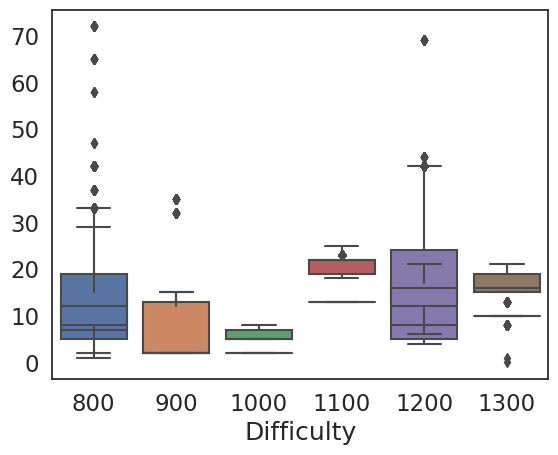

In [16]:
difficulty = {
    '1A': 1000,
    '4A': 800,
    '4C': 1300,
    '50A': 800,
    '208A': 900,
    '214A': 800,
    '255A': 800,
    '265A': 800,
    '492B': 1200,
    '510A': 800,
    '1097A':800, 
    '1360B':800, 
    '1363A':1200, 
    '1364A':1200, 
    '1369B':1200, 
    '1370A':800, 
    '1382B':1100, 
    '1385A':800, 
    '1391A':800, 
    '1391B':800
}
filtered['Difficulty'] = filtered['Problem'].map(difficulty)
# Lines of code
filtered.groupby('Problem')['Correct File', 'Incorrect File'].describe()
# Lines of code
display(filtered.groupby('Difficulty')['Correct Locs'].describe())
# Exprs
display(filtered.groupby('Difficulty')['Correct Exprs'].describe())
sns.set(font_scale=1.5)
sns.set_style("white")
ax = sns.boxplot(
    data=filtered, 
    y="Correct Locs",
    x="Difficulty",
    orient="v")
ax.set_ylabel("")
ax.set_xlabel("Difficulty")
# plt.show()
plt.savefig('locs_difficulty_boxplot.pdf', format="pdf", bbox_inches='tight')
ax = sns.boxplot(
    data=filtered, 
    y="Correct Exprs",
    x="Difficulty",
    orient="v")
ax.set_ylabel("")
ax.set_xlabel("Difficulty")
# plt.show()
plt.savefig('exprs_difficulty_boxplot.pdf', format="pdf", bbox_inches='tight')

In [17]:
filtered['Correct Exprs'].describe()

count    15132.000000
mean        15.477399
std          8.640850
min          0.000000
25%          8.000000
50%         13.000000
75%         23.000000
max         69.000000
Name: Correct Exprs, dtype: float64

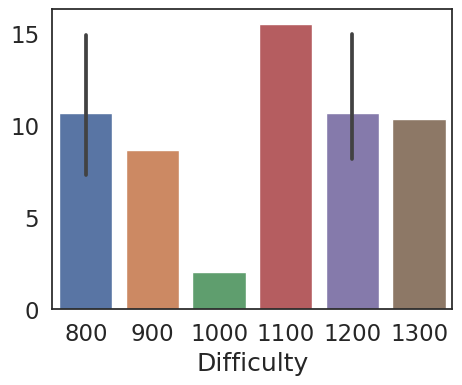

In [18]:
# Difficulty to LOCS
fig = plt.figure(figsize =(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
locs = filtered
locs = [2.00,6.94,10.3,2.38,8.64,11.8,12.5,4.95,9.03,17.7,16.1,8.61,17.0,8.63,8.00,4.53,15.5,26.8,5.83,9.91]
diff = [1000,800,1300,800,900,800,800,800,1200,800,800,800,1200,1200,1200,800,1100,800,800,800]
sns.barplot(x=diff, y=locs, ax=ax)
# ax.set_ylabel("Lines of Code")
ax.set_xlabel("Difficulty")
plt.savefig('locs_difficulty.pdf', format="pdf", bbox_inches='tight')

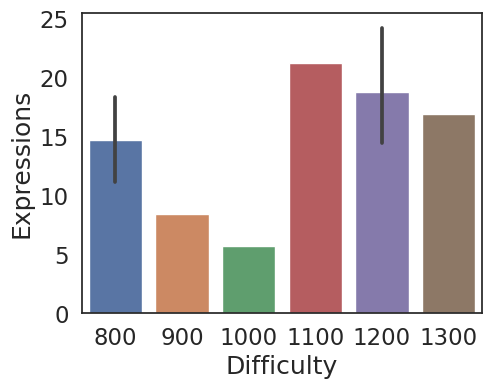

In [19]:
# Difficulty to Exprs
fig = plt.figure(figsize =(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
exprs = [5.73,5.02,16.9 ,4.90,8.44,21.0 ,13.1 ,11.6 ,18.7 ,18.4 ,17.6 ,18.1 ,27.5 ,14.5 ,14.4 ,10.0 ,21.2 ,24.9 ,9.23,23.1]
diff = [1000,800,1300,800,900,800,800,800,1200,800,800,800,1200,1200,1200,800,1100,800,800,800]
sns.barplot(x=diff, y=exprs, ax=ax)
ax.set_ylabel("Expressions")
ax.set_xlabel("Difficulty")
plt.savefig('exprs_difficulty.pdf', format="pdf", bbox_inches='tight')

In [44]:
# Successfully repaired out of all the incorrect numbers
print('Number of failed repairs')
display(clara.groups_analyze(df=filtered[filtered['Repairs'].isna()==True], columns=['Technique']))
print('Number of successful repairs')
display(clara.groups_analyze(df=filtered[filtered['Repairs'].isna()!=True], columns=['Technique']))
print('Number of total repairs')
display(clara.groups_analyze(df=filtered, columns=['Technique']))

# 
repaired_techniques = (filtered[filtered['Repairs'].isna()!=True].groupby('Technique')['Problem'].count()\
        /filtered.groupby('Technique')['Problem'].count())
display(repaired_techniques)
repaired_tech_problem = (filtered[filtered['Repairs'].isna()!=True].groupby(['Technique','Problem'])['Problem'].count()\
        /filtered.groupby(['Technique', 'Problem'])['Problem'].count())
display(repaired_tech_problem.values)
display(repaired_tech_problem.index)
display(repaired_tech_problem)

Number of failed repairs


,Technique
Technique,
CLARA,14930
FA(L),8534
FA(L+E),8468


Number of successful repairs


,Technique
Technique,
CLARA,758
FA(L),7154
FA(L+E),7220


Number of total repairs


,Technique
Technique,
CLARA,15688
FA(L),15688
FA(L+E),15688


Technique
CLARA      0.048317
FA(L)      0.456017
FA(L+E)    0.460224
Name: Problem, dtype: float64

array([0.01363636, 0.18644068, 0.00667408, 0.01101533, 0.01392405,
       0.11752988, 0.16765286, 0.02021478, 0.0554633 , 0.05      ,
       0.13240418, 0.00671141, 0.03797468, 0.03403566, 0.38      ,
       0.00802139, 0.25495751, 0.04143646, 0.17989418,        nan,
       0.22727273, 0.93220339, 0.91101224, 0.2112069 , 0.62025316,
       0.75398406, 0.79289941, 0.47946936, 0.34805712, 0.78      ,
       0.96864111, 0.63758389, 0.18565401, 0.42301459, 0.79      ,
       0.36096257, 0.66572238, 0.50276243, 0.97354497, 0.48348348,
       0.23181818, 0.93220339, 0.91101224, 0.21096743, 0.62405063,
       0.7559761 , 0.79289941, 0.48010107, 0.34905347, 0.78      ,
       0.97560976, 0.63087248, 0.19409283, 0.42139384, 0.79      ,
       0.36363636, 0.68838527, 0.50552486, 0.96296296, 0.62162162])

MultiIndex([(  'CLARA', '1097A'),
            (  'CLARA', '1360B'),
            (  'CLARA', '1363A'),
            (  'CLARA', '1364A'),
            (  'CLARA', '1369B'),
            (  'CLARA', '1370A'),
            (  'CLARA', '1382B'),
            (  'CLARA', '1385A'),
            (  'CLARA', '1391A'),
            (  'CLARA', '1391B'),
            (  'CLARA',    '1A'),
            (  'CLARA',  '208A'),
            (  'CLARA',  '214A'),
            (  'CLARA',  '255A'),
            (  'CLARA',  '265A'),
            (  'CLARA',  '492B'),
            (  'CLARA',    '4A'),
            (  'CLARA',    '4C'),
            (  'CLARA',   '50A'),
            (  'CLARA',  '510A'),
            (  'FA(L)', '1097A'),
            (  'FA(L)', '1360B'),
            (  'FA(L)', '1363A'),
            (  'FA(L)', '1364A'),
            (  'FA(L)', '1369B'),
            (  'FA(L)', '1370A'),
            (  'FA(L)', '1382B'),
            (  'FA(L)', '1385A'),
            (  'FA(L)', '1391A'),
            ( 

Technique  Problem
CLARA      1097A      0.013636
           1360B      0.186441
           1363A      0.006674
           1364A      0.011015
           1369B      0.013924
           1370A      0.117530
           1382B      0.167653
           1385A      0.020215
           1391A      0.055463
           1391B      0.050000
           1A         0.132404
           208A       0.006711
           214A       0.037975
           255A       0.034036
           265A       0.380000
           492B       0.008021
           4A         0.254958
           4C         0.041436
           50A        0.179894
           510A            NaN
FA(L)      1097A      0.227273
           1360B      0.932203
           1363A      0.911012
           1364A      0.211207
           1369B      0.620253
           1370A      0.753984
           1382B      0.792899
           1385A      0.479469
           1391A      0.348057
           1391B      0.780000
           1A         0.968641
           208A     

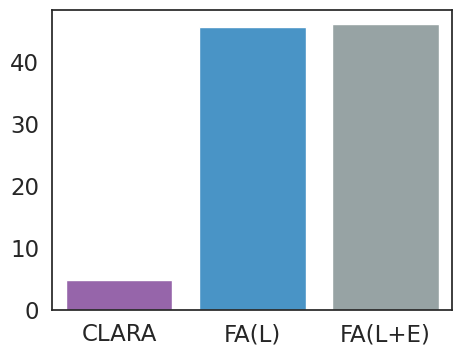

In [45]:
sns.set(font_scale=1.5)
sns.set_style("white")
fig = plt.figure(figsize =(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=repaired_techniques.index, y=(repaired_techniques.values)*100, ax=ax, palette=palette)
ax.set_ylabel("")
ax.set_xlabel("")
plt.savefig('successful_repair_by_experiment.pdf', format="pdf", bbox_inches='tight')

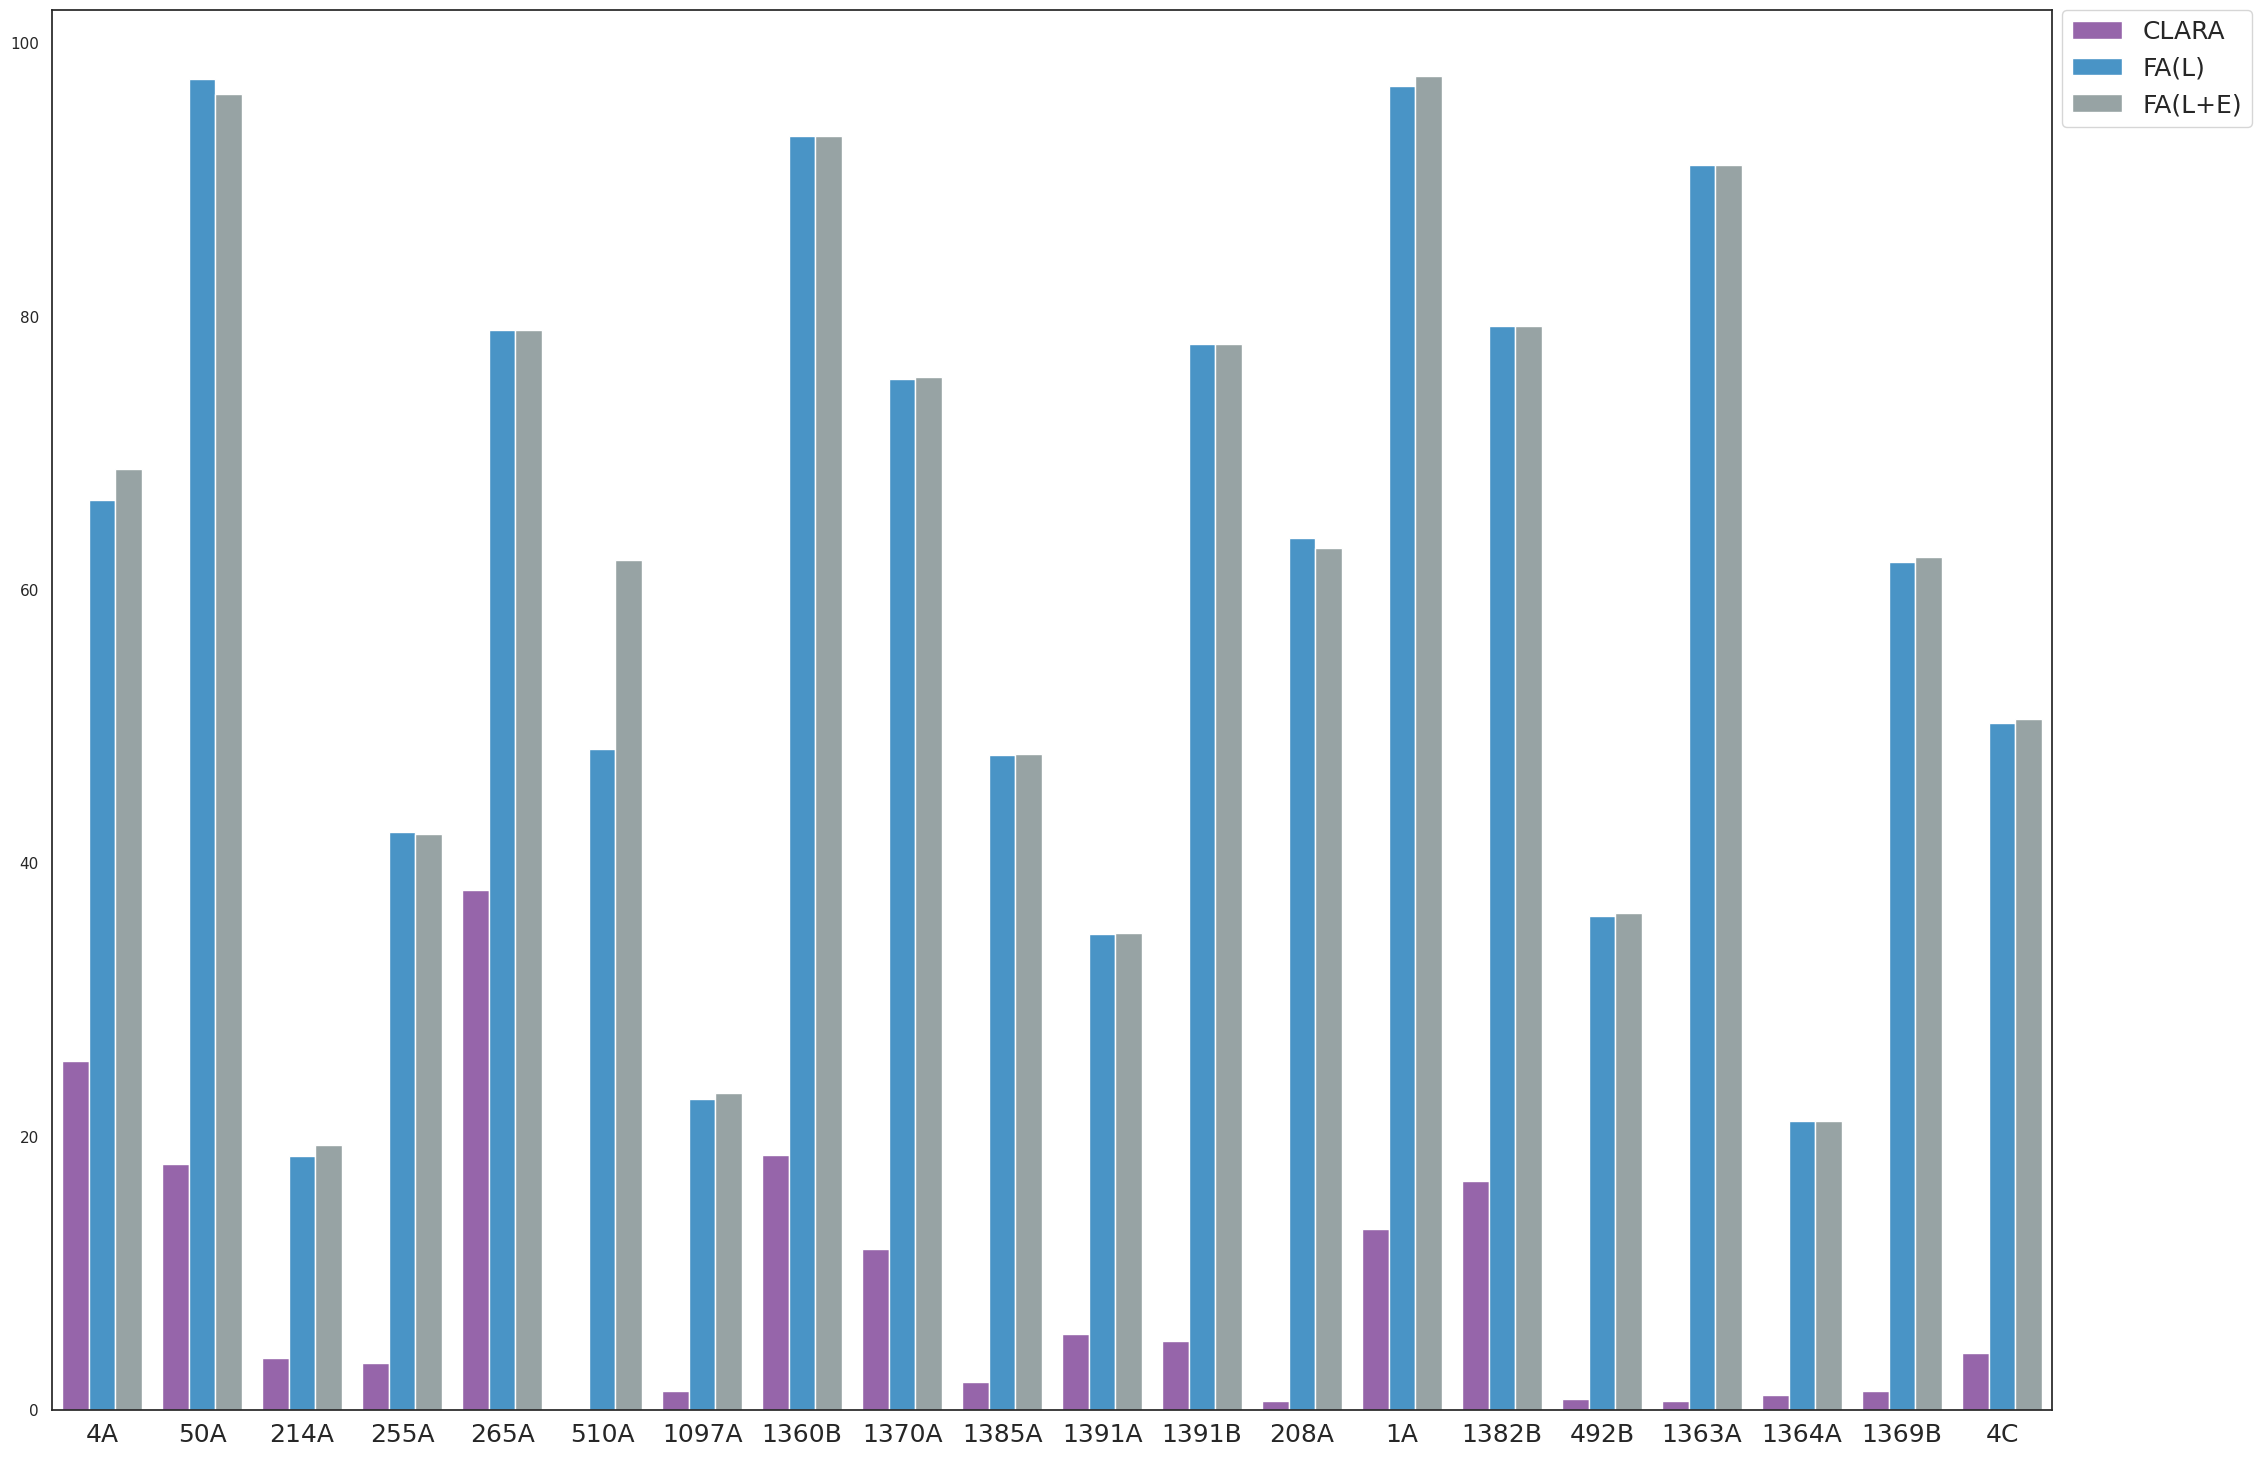

In [63]:
sns.set(font_scale=1)
sns.set_style("white")
fig = plt.figure(figsize =(20, 14))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=repaired_tech_problem.index.get_level_values('Problem'),
            hue=repaired_tech_problem.index.get_level_values('Technique'), 
            y=repaired_tech_problem.values*100, ax=ax, palette=palette,
            order=[
                '4A',
                '50A',
                '214A',
                '255A',
                '265A',
                '510A',
                '1097A',
                '1360B',
                '1370A',
                '1385A',
                '1391A',
                '1391B',
                '208A',
                '1A',
                '1382B',
                '492B',
                '1363A',
                '1364A',
                '1369B',
                '4C'
                ])
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticklabels([
                '4A',
                '50A',
                '214A',
                '255A',
                '265A',
                '510A',
                '1097A',
                '1360B',
                '1370A',
                '1385A',
                '1391A',
                '1391B',
                '208A',
                '1A',
                '1382B',
                '492B',
                '1363A',
                '1364A',
                '1369B',
                '4C'
                ], size=18)
ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1), borderaxespad=0, fontsize=18)
plt.savefig('successful_repair_by_problem.pdf', format="pdf", bbox_inches='tight')

In [41]:
filtered['locs_bin'] = pd.cut(np.array(filtered['Correct Locs']), bins=[0,10,20,30,40,50,60,70,80])
filtered[filtered['locs_bin'].isna() != True]['Correct File']
def add_locs_bin(x, filtered):
    row = filtered.loc[(filtered['locs_bin'].isna() != True)]
    row = row[row['Correct File'] == x['Correct File']]
    if len(row['locs_bin']) > 0:
        x['locs_bin'] = row['locs_bin'].iloc[0]
    return x
filtered = filtered.apply(lambda x: add_locs_bin(x, filtered), axis=1)
filtered[filtered['locs_bin'].isna() != True]['Correct File']

0         87664234
1         87664234
2         87664234
21        87559082
22        87559082
            ...   
258803    88676701
258804    88676701
258841    83643436
258842    83643436
258843    83643436
Name: Correct File, Length: 24063, dtype: object

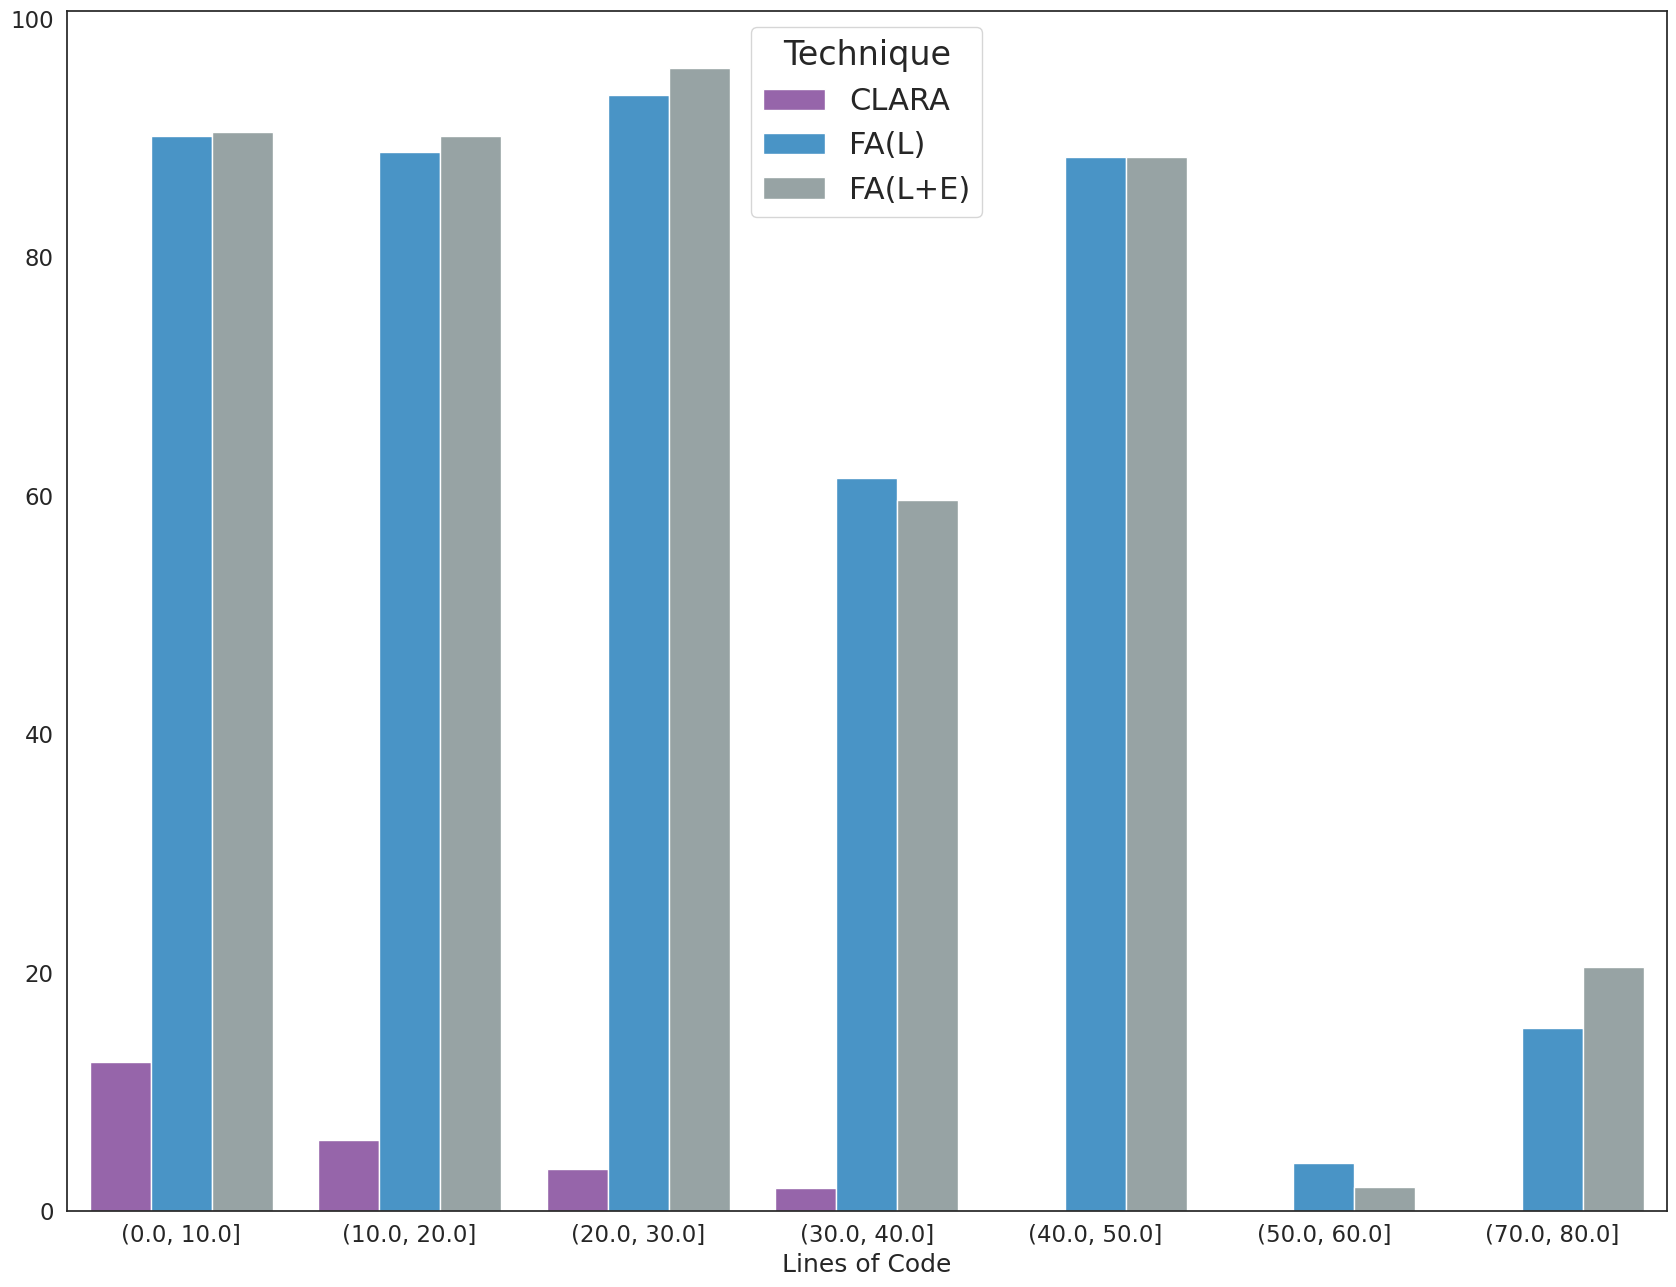

In [24]:
repaired_techniques = (filtered[filtered['Repairs'].isna()!=True].groupby('Technique')['Problem'].count()\
        /filtered.groupby('Technique')['Problem'].count())
# display(repaired_techniques)
repaired_tech_problem = (filtered[filtered['Repairs'].isna()!=True].groupby(['Technique', 'locs_bin'])['Problem'].count()\
        /filtered.groupby(['Technique', 'locs_bin'])['Problem'].count())
# display(repaired_tech_problem.values)
# display(repaired_tech_problem.index)

fig = plt.figure(figsize =(16, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=2)
sns.set_style("white")
sns.barplot(x=repaired_tech_problem.index.get_level_values('locs_bin'),
            hue=repaired_tech_problem.index.get_level_values('Technique'), 
            y=repaired_tech_problem.values*100, ax=ax, palette=palette)
ax.set_ylabel("")
ax.set_xlabel("Lines of Code")
plt.savefig('successful_repair_by_loc.pdf', format="pdf", bbox_inches='tight')

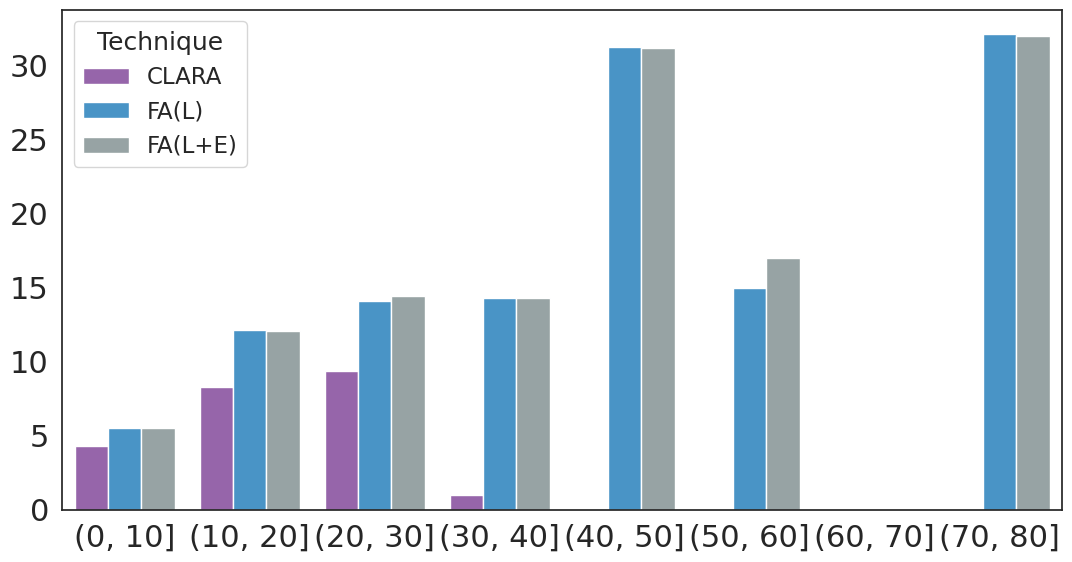

In [25]:
filtered['locs_bin'] = pd.cut(np.array(filtered['Correct Locs']), bins=[0,10,20,30,40,50,60,70,80])
locs = filtered.groupby(['locs_bin', 'Technique'])['Repairs'].mean()
# y = np.array(filtered['Repairs'])
# z = np.array(filtered['Technique'])
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=locs.index.get_level_values('locs_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=palette)
ax.set_ylabel("")
ax.set_xlabel("")
plt.savefig('average_repairs_by_loc.pdf', format="pdf", bbox_inches='tight')

Text(0.5, 0, 'Lines of Code')

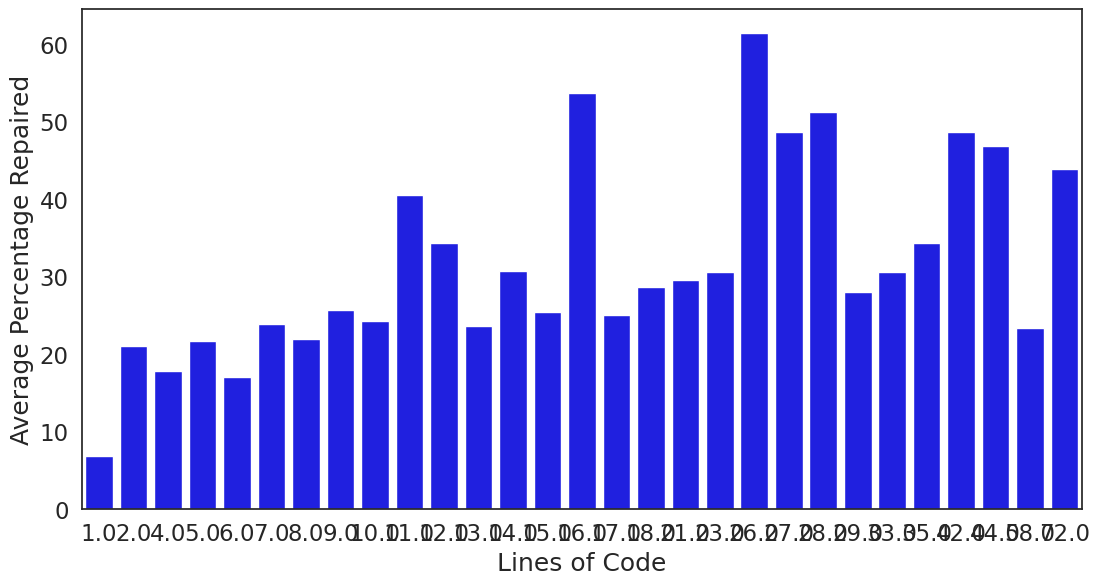

In [26]:
locs = filtered.groupby(['Correct Locs'])['Percentage Repaired'].mean()
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=locs.index,
            color='blue',
            y=locs.values, ax=ax)
ax.set_ylabel("Average Percentage Repaired")
ax.set_xlabel("Lines of Code")

locs_bin  Technique
(0, 10]   CLARA        21.815766
          FA(L)        21.797503
          FA(L+E)      22.018084
(10, 20]  CLARA        20.582133
          FA(L)        26.622989
          FA(L+E)      27.189214
(20, 30]  CLARA        18.928125
          FA(L)        30.963671
          FA(L+E)      31.989388
(30, 40]  CLARA         1.562500
          FA(L)        32.360177
          FA(L+E)      32.594571
(40, 50]  CLARA              NaN
          FA(L)        48.564735
          FA(L+E)      48.478134
(50, 60]  CLARA              NaN
          FA(L)        22.388060
          FA(L+E)      25.373134
(60, 70]  CLARA              NaN
          FA(L)              NaN
          FA(L+E)            NaN
(70, 80]  CLARA              NaN
          FA(L)        43.460502
          FA(L+E)      44.199826
Name: Percentage Repaired, dtype: float64

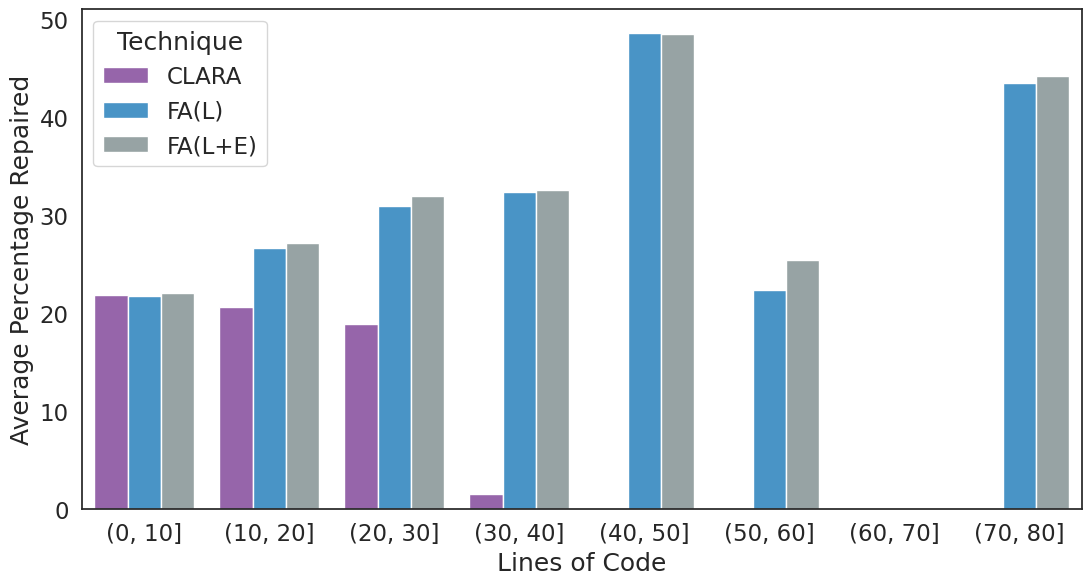

In [27]:
locs = filtered.groupby(['locs_bin', 'Technique'])['Percentage Repaired'].mean()
display(locs)
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=locs.index.get_level_values('locs_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=palette)
ax.set_ylabel("Average Percentage Repaired")
ax.set_xlabel("Lines of Code")
plt.savefig('average_percentage_repairs_by_loc.pdf', format="pdf", bbox_inches='tight')

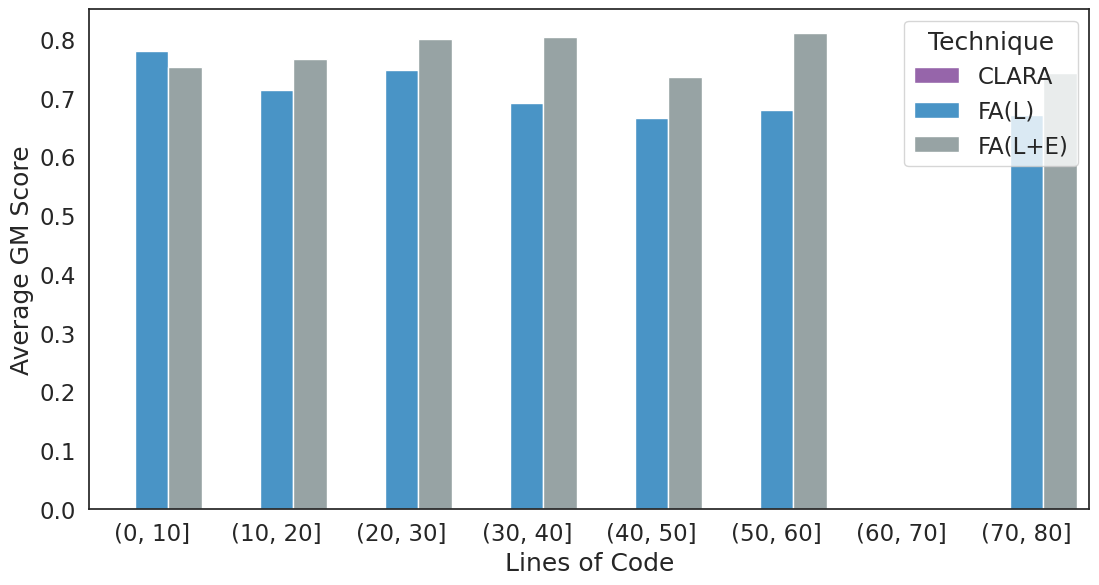

In [28]:
locs = filtered.groupby(['locs_bin', 'Technique'])['GM Score'].mean()
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=locs.index.get_level_values('locs_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=palette)
ax.set_ylabel("Average GM Score")
ax.set_xlabel("Lines of Code")
plt.savefig('average_gm_score_by_loc.pdf', format="pdf", bbox_inches='tight')

In [29]:
filtered['exprs_bin'] = pd.cut(np.array(filtered['Correct Exprs']), bins=[0,10,20,30,40,50,60,70,80])
filtered[filtered['exprs_bin'].isna() != True]['Correct File']
def add_locs_bin(x, filtered):
    row = filtered.loc[(filtered['exprs_bin'].isna() != True)]
    row = row[row['Correct File'] == x['Correct File']]
    if len(row['exprs_bin']) > 0:
        x['exprs_bin'] = row['exprs_bin'].iloc[0]
    return x
filtered = filtered.apply(lambda x: add_locs_bin(x, filtered), axis=1)

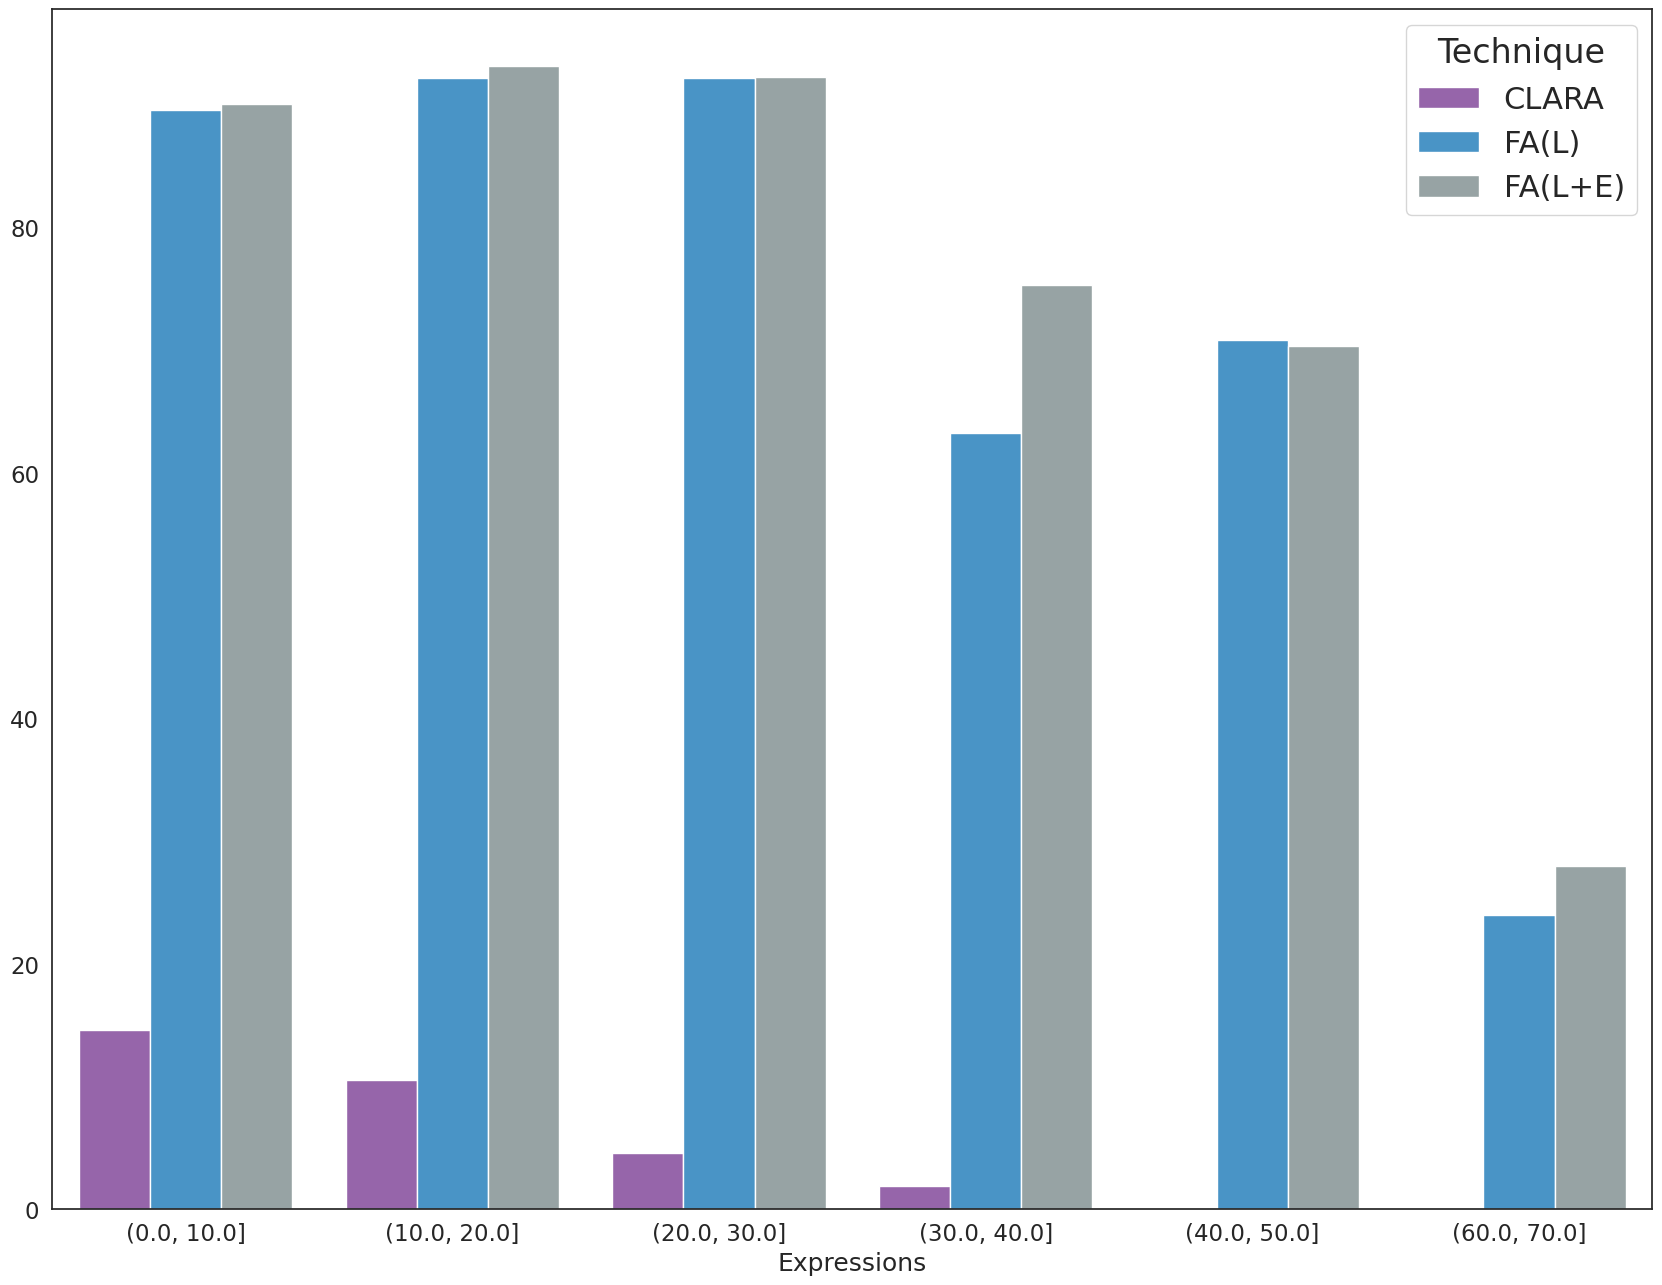

In [30]:
repaired_techniques = (filtered[filtered['Repairs'].isna()!=True].groupby('Technique')['Problem'].count()\
        /filtered.groupby('Technique')['Problem'].count())
# display(repaired_techniques)
repaired_tech_problem = (filtered[filtered['Repairs'].isna()!=True].groupby(['Technique', 'exprs_bin'])['Problem'].count()\
        /filtered.groupby(['Technique', 'exprs_bin'])['Problem'].count())
# display(repaired_tech_problem.values)
# display(repaired_tech_problem.index)

fig = plt.figure(figsize =(16, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=2)
sns.set_style("white")
sns.barplot(x=repaired_tech_problem.index.get_level_values('exprs_bin'),
            hue=repaired_tech_problem.index.get_level_values('Technique'), 
            y=repaired_tech_problem.values*100, ax=ax, palette=palette)
ax.set_ylabel("")
ax.set_xlabel("Expressions")
plt.savefig('successful_repair_by_exprs.pdf', format="pdf", bbox_inches='tight')

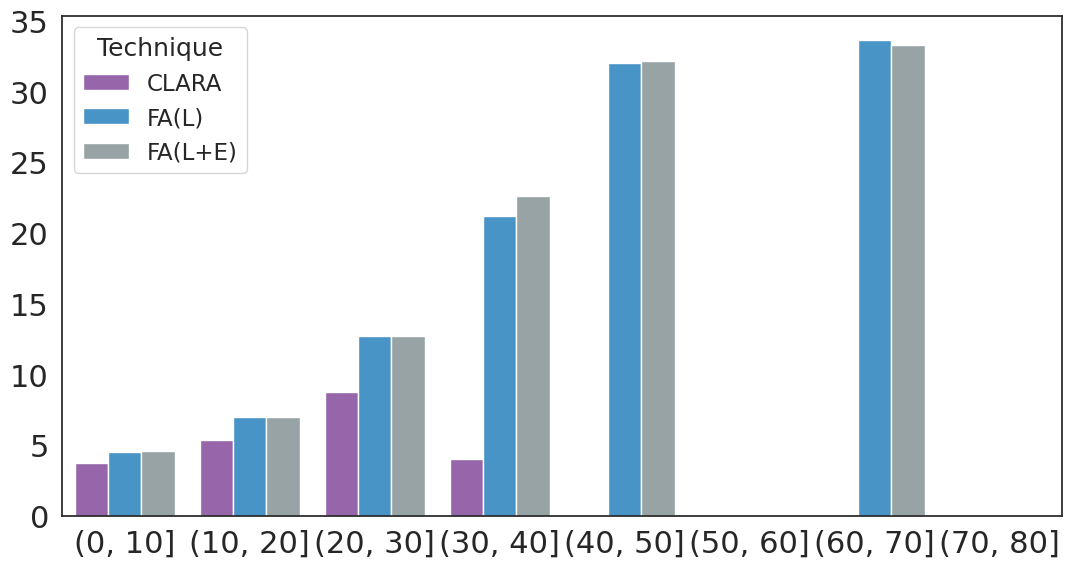

In [31]:
filtered['exprs_bin'] = pd.cut(np.array(filtered['Correct Exprs']), bins=[0,10,20,30,40,50,60,70,80])
locs = filtered.groupby(['exprs_bin', 'Technique'])['Repairs'].mean()
# y = np.array(filtered['Repairs'])
# z = np.array(filtered['Technique'])
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=locs.index.get_level_values('exprs_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=palette)
ax.set_ylabel("")
ax.set_xlabel("")
plt.savefig('average_repairs_by_exprs.pdf', format="pdf", bbox_inches='tight')

In [32]:
filtered['diff_bin'] = pd.cut(np.array(filtered['Difficulty']), bins=[700, 800, 1300])
filtered[filtered['diff_bin'].isna() != True]['Correct File']
def add_locs_bin(x, filtered):
    row = filtered.loc[(filtered['diff_bin'].isna() != True)]
    row = row[row['Correct File'] == x['Correct File']]
    if len(row['diff_bin']) > 0:
        x['diff_bin'] = row['diff_bin'].iloc[0]
    return x
filtered = filtered.apply(lambda x: add_locs_bin(x, filtered), axis=1)
repaired_techniques = (filtered[filtered['Repairs'].isna()!=True].groupby('Technique')['Problem'].count()\
        /filtered.groupby('Technique')['Problem'].count())
# display(repaired_techniques)
repaired_tech_problem = (filtered[filtered['Repairs'].isna()!=True].groupby(['Technique', 'diff_bin'])['Problem'].count()\
        /filtered.groupby(['Technique', 'diff_bin'])['Problem'].count())
display(repaired_tech_problem.values)
display(repaired_tech_problem.index)


array([0.06790275, 0.02717391, 0.47531925, 0.43518028, 0.48280943,
       0.43584305])

MultiIndex([(  'CLARA',  (700, 800]),
            (  'CLARA', (800, 1300]),
            (  'FA(L)',  (700, 800]),
            (  'FA(L)', (800, 1300]),
            ('FA(L+E)',  (700, 800]),
            ('FA(L+E)', (800, 1300])],
           names=['Technique', 'diff_bin'])

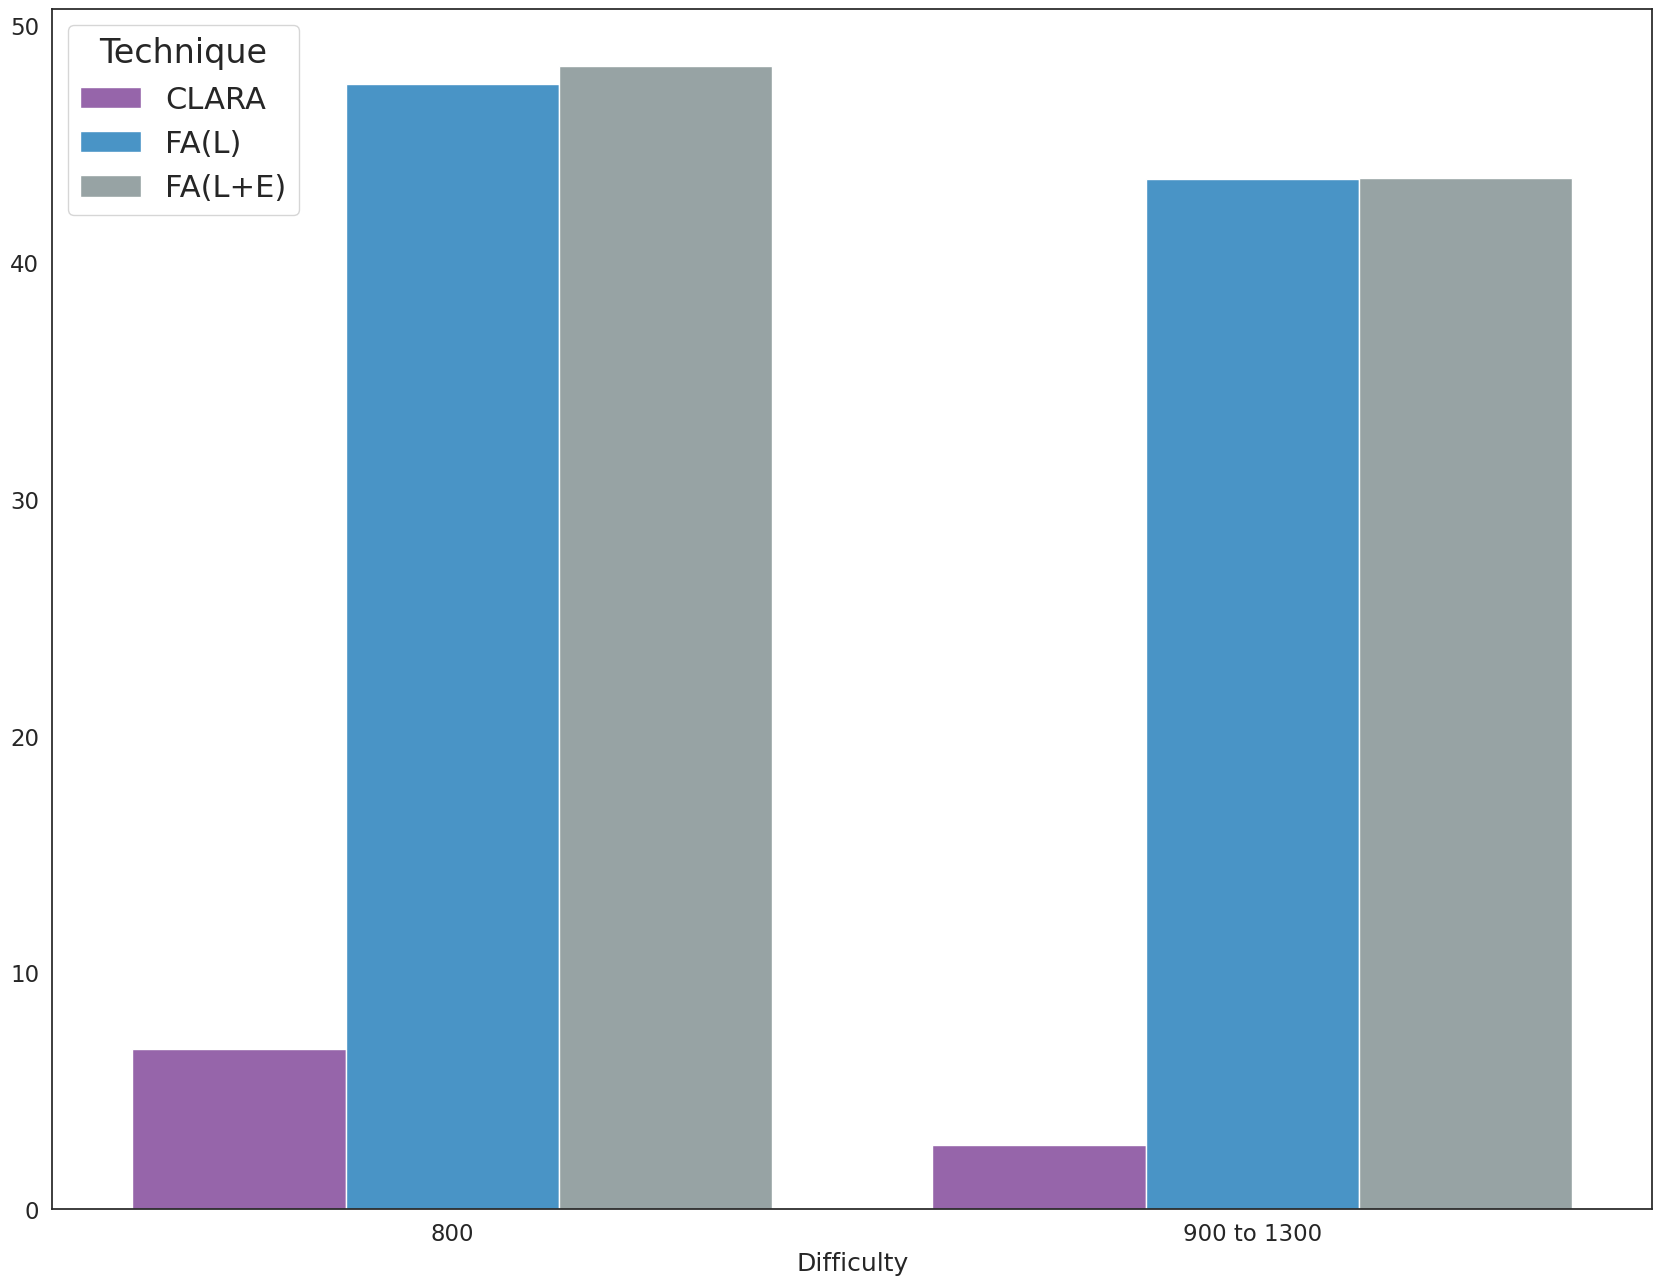

In [33]:
fig = plt.figure(figsize =(16, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=2)
sns.set_style("white")
sns.barplot(x=repaired_tech_problem.index.get_level_values('diff_bin'),
            hue=repaired_tech_problem.index.get_level_values('Technique'), 
            y=repaired_tech_problem.values*100, ax=ax, palette=palette)
ax.set_ylabel("")
ax.set_xlabel("Difficulty")
ax.set_xticklabels(['800', '900 to 1300'])
plt.savefig('successful_repair_by_diff.pdf', format="pdf", bbox_inches='tight')

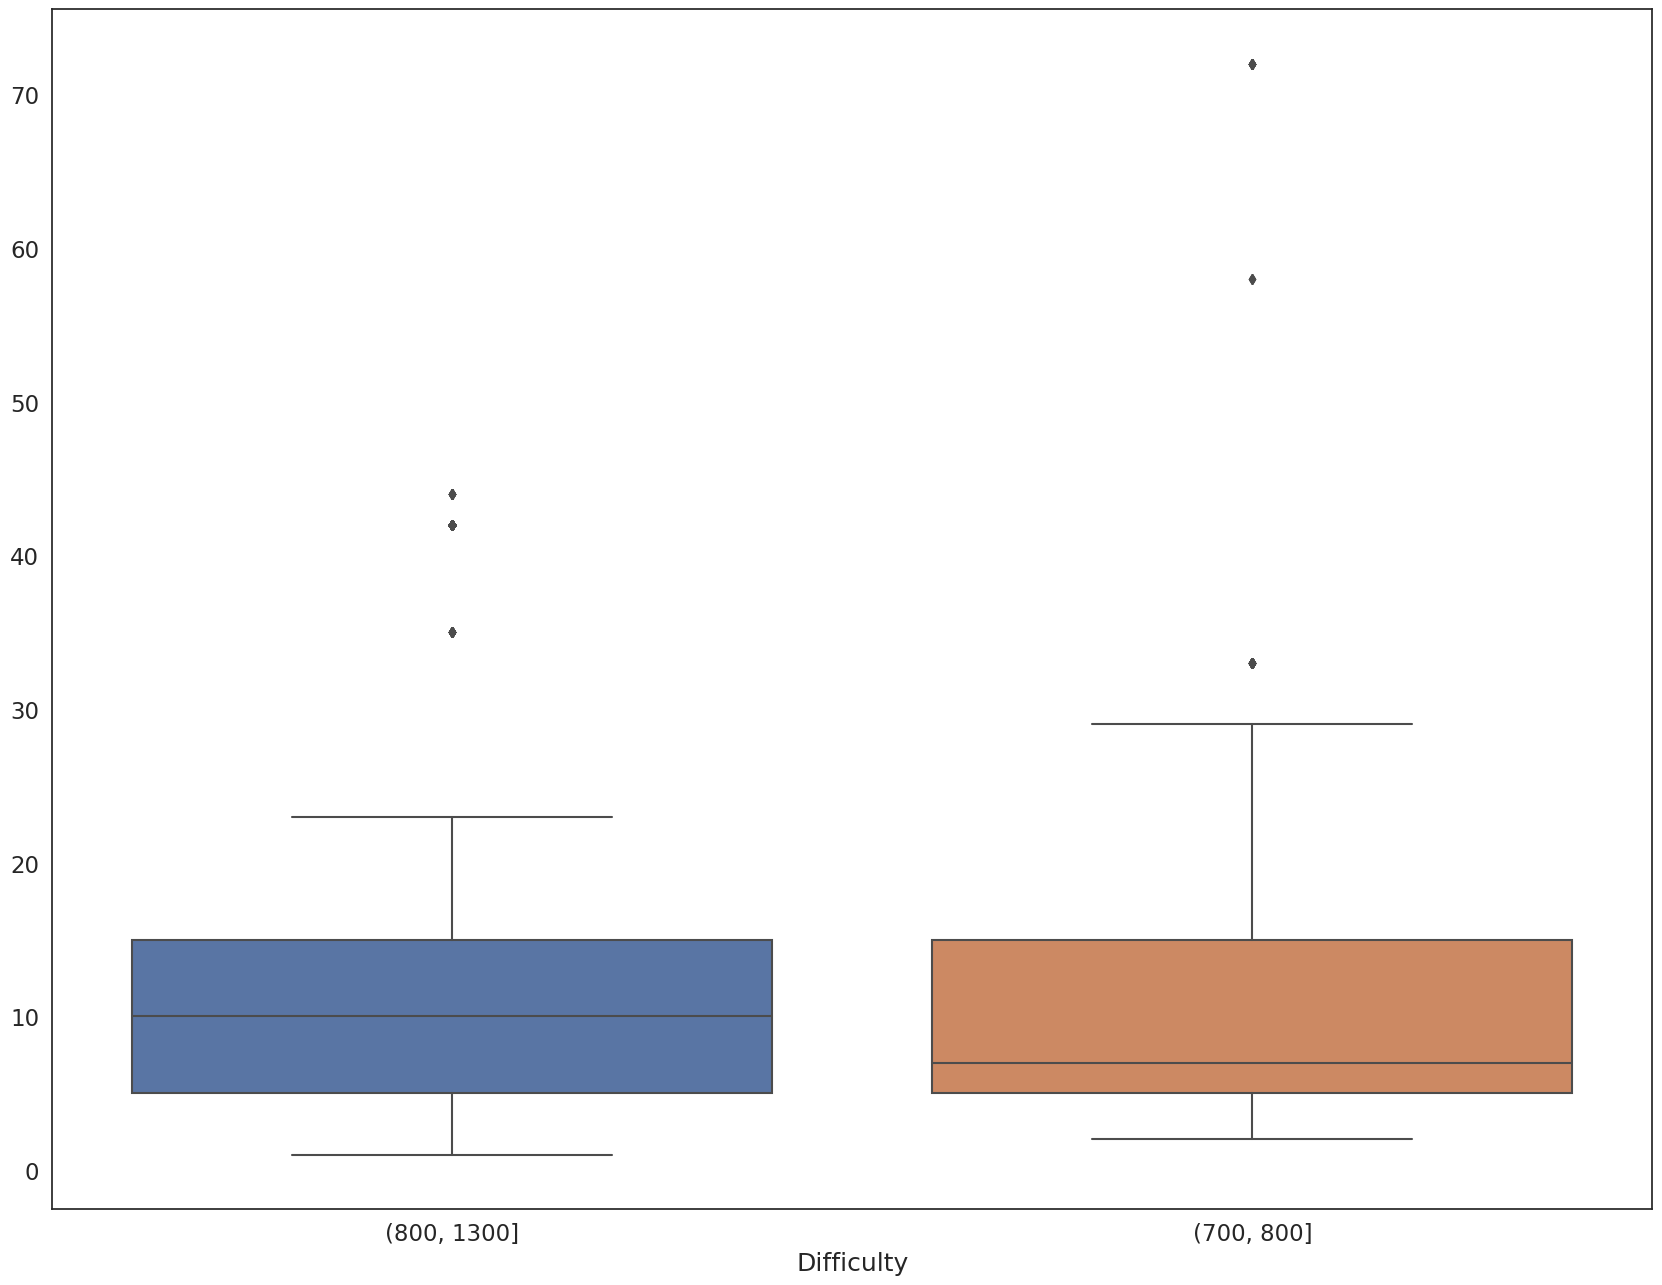

In [42]:
fig = plt.figure(figsize =(16, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=2)
sns.set_style("white")
# sns.barplot(x=repaired_tech_problem.index.get_level_values('diff_bin'),
#             hue=repaired_tech_problem.index.get_level_values('Technique'), 
#             y=repaired_tech_problem.values*100, ax=ax, palette=palette)
ax = sns.boxplot(
    data=filtered, 
    y="Correct Locs",
    x="diff_bin",
    orient="v")
ax.set_ylabel("")
ax.set_xlabel("Difficulty")
# ax.set_xticklabels(['800', '900 to 1300'])
plt.savefig('locs_by_diff.pdf', format="pdf", bbox_inches='tight')

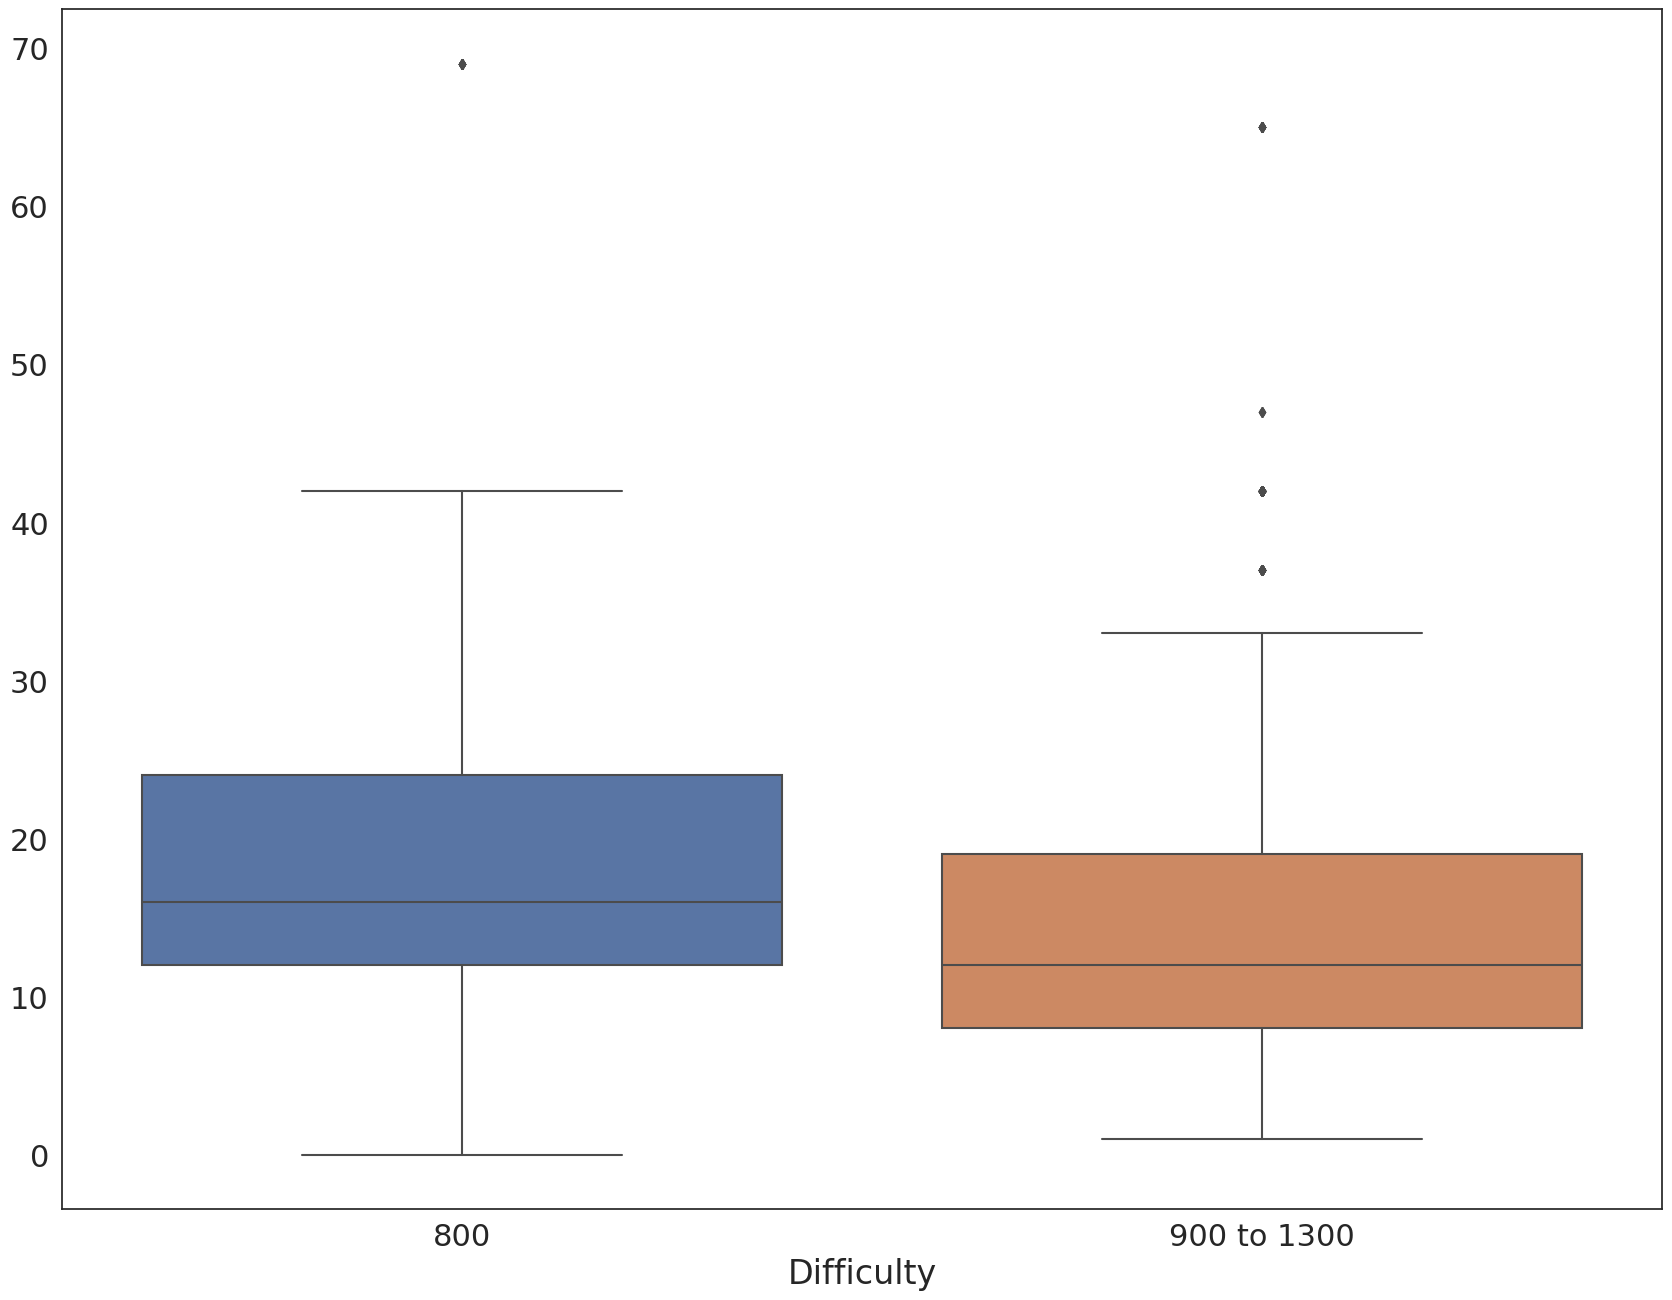

In [35]:
fig = plt.figure(figsize =(16, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=2)
sns.set_style("white")
# sns.barplot(x=repaired_tech_problem.index.get_level_values('diff_bin'),
#             hue=repaired_tech_problem.index.get_level_values('Technique'), 
#             y=repaired_tech_problem.values*100, ax=ax, palette=palette)
ax = sns.boxplot(
    data=filtered, 
    y="Correct Exprs",
    x="diff_bin",
    orient="v")
ax.set_ylabel("")
ax.set_xlabel("Difficulty")
ax.set_xticklabels(['800', '900 to 1300'])
plt.savefig('exprs_by_diff.pdf', format="pdf", bbox_inches='tight')

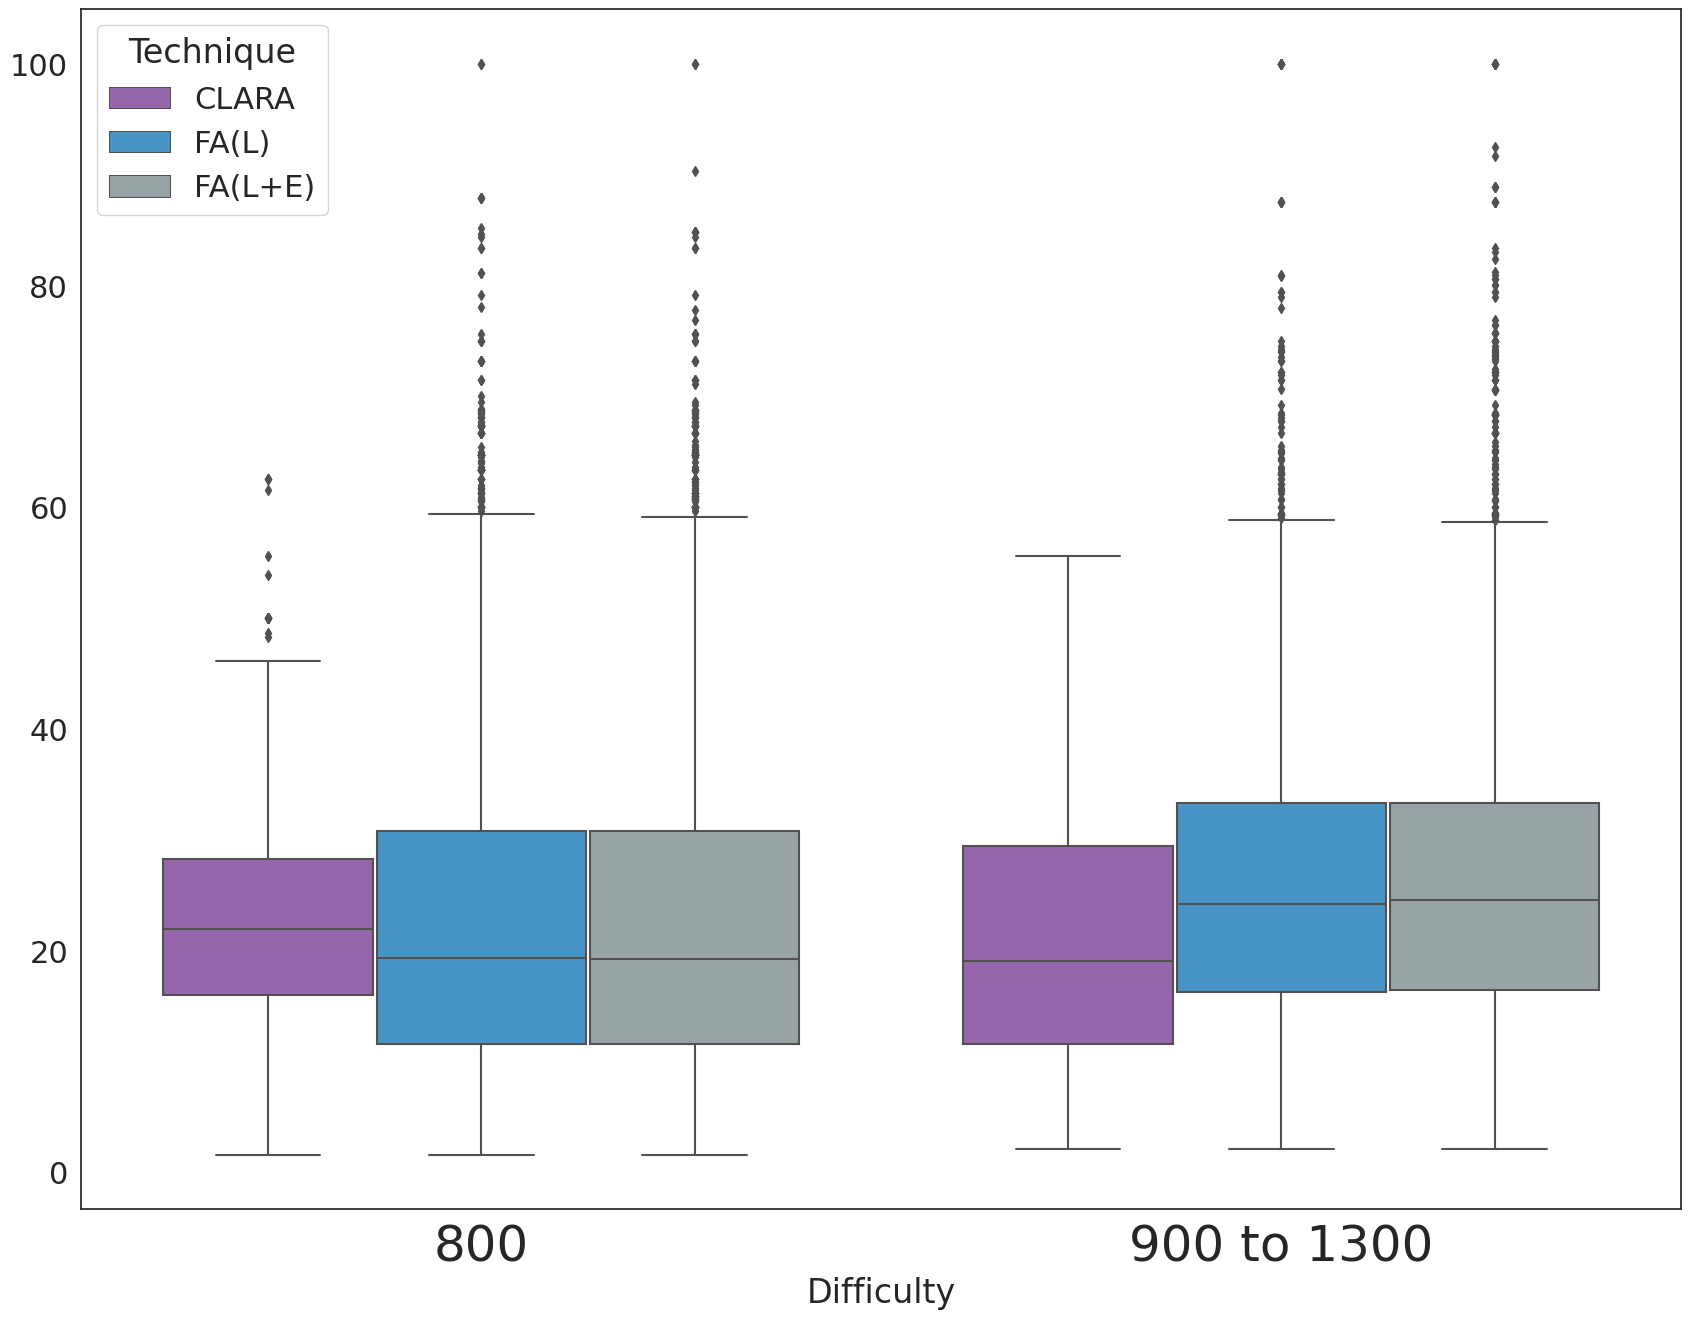

In [36]:
fig = plt.figure(figsize =(16, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=2)
sns.set_style("white")
# sns.barplot(x=repaired_tech_problem.index.get_level_values('diff_bin'),
#             hue=repaired_tech_problem.index.get_level_values('Technique'), 
#             y=repaired_tech_problem.values*100, ax=ax, palette=palette)
ax = sns.boxplot(
    data=filtered, 
    y="Percentage Repaired",
    x="diff_bin",
    orient="v",
    hue="Technique",
    palette=palette)
ax.set_ylabel("")
ax.set_xlabel("Difficulty")
ax.set_xticklabels(['800', '900 to 1300'], size=36)
plt.savefig('percentage_repaired_by_diff.pdf', format="pdf", bbox_inches='tight')

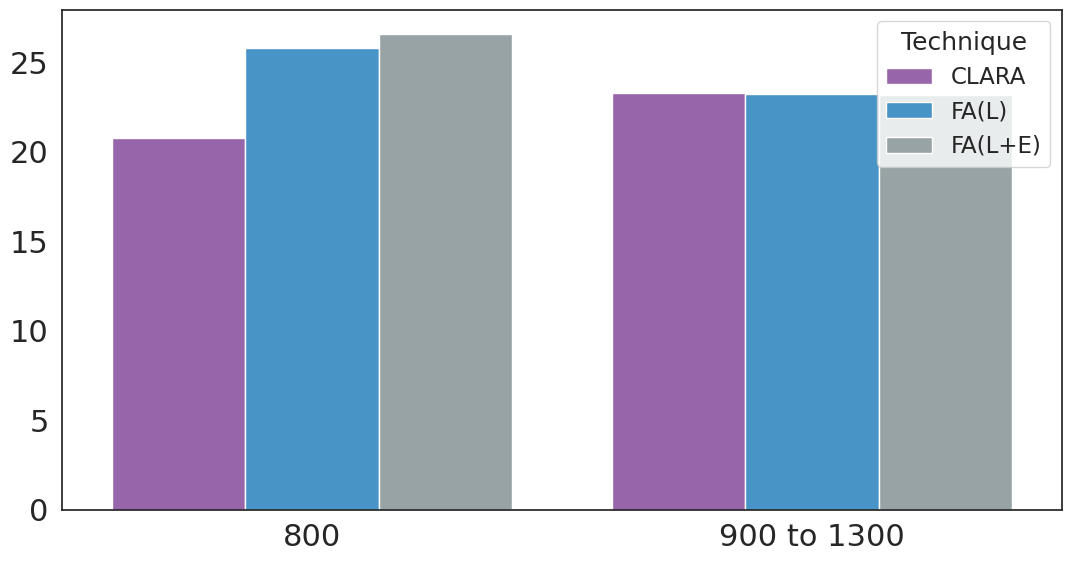

In [37]:
# filtered['exprs_bin'] = pd.cut(np.array(filtered['Correct Exprs']), bins=[0,10,20,30,40,50,60,70,80])
locs = filtered.groupby(['diff_bin', 'Technique'])['Percentage Repaired'].mean()
# y = np.array(filtered['Repairs'])
# z = np.array(filtered['Technique'])
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=locs.index.get_level_values('diff_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=palette)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticklabels(['800', '900 to 1300'])
plt.savefig('percentage_repaired_by_diff_bar.pdf', format="pdf", bbox_inches='tight')

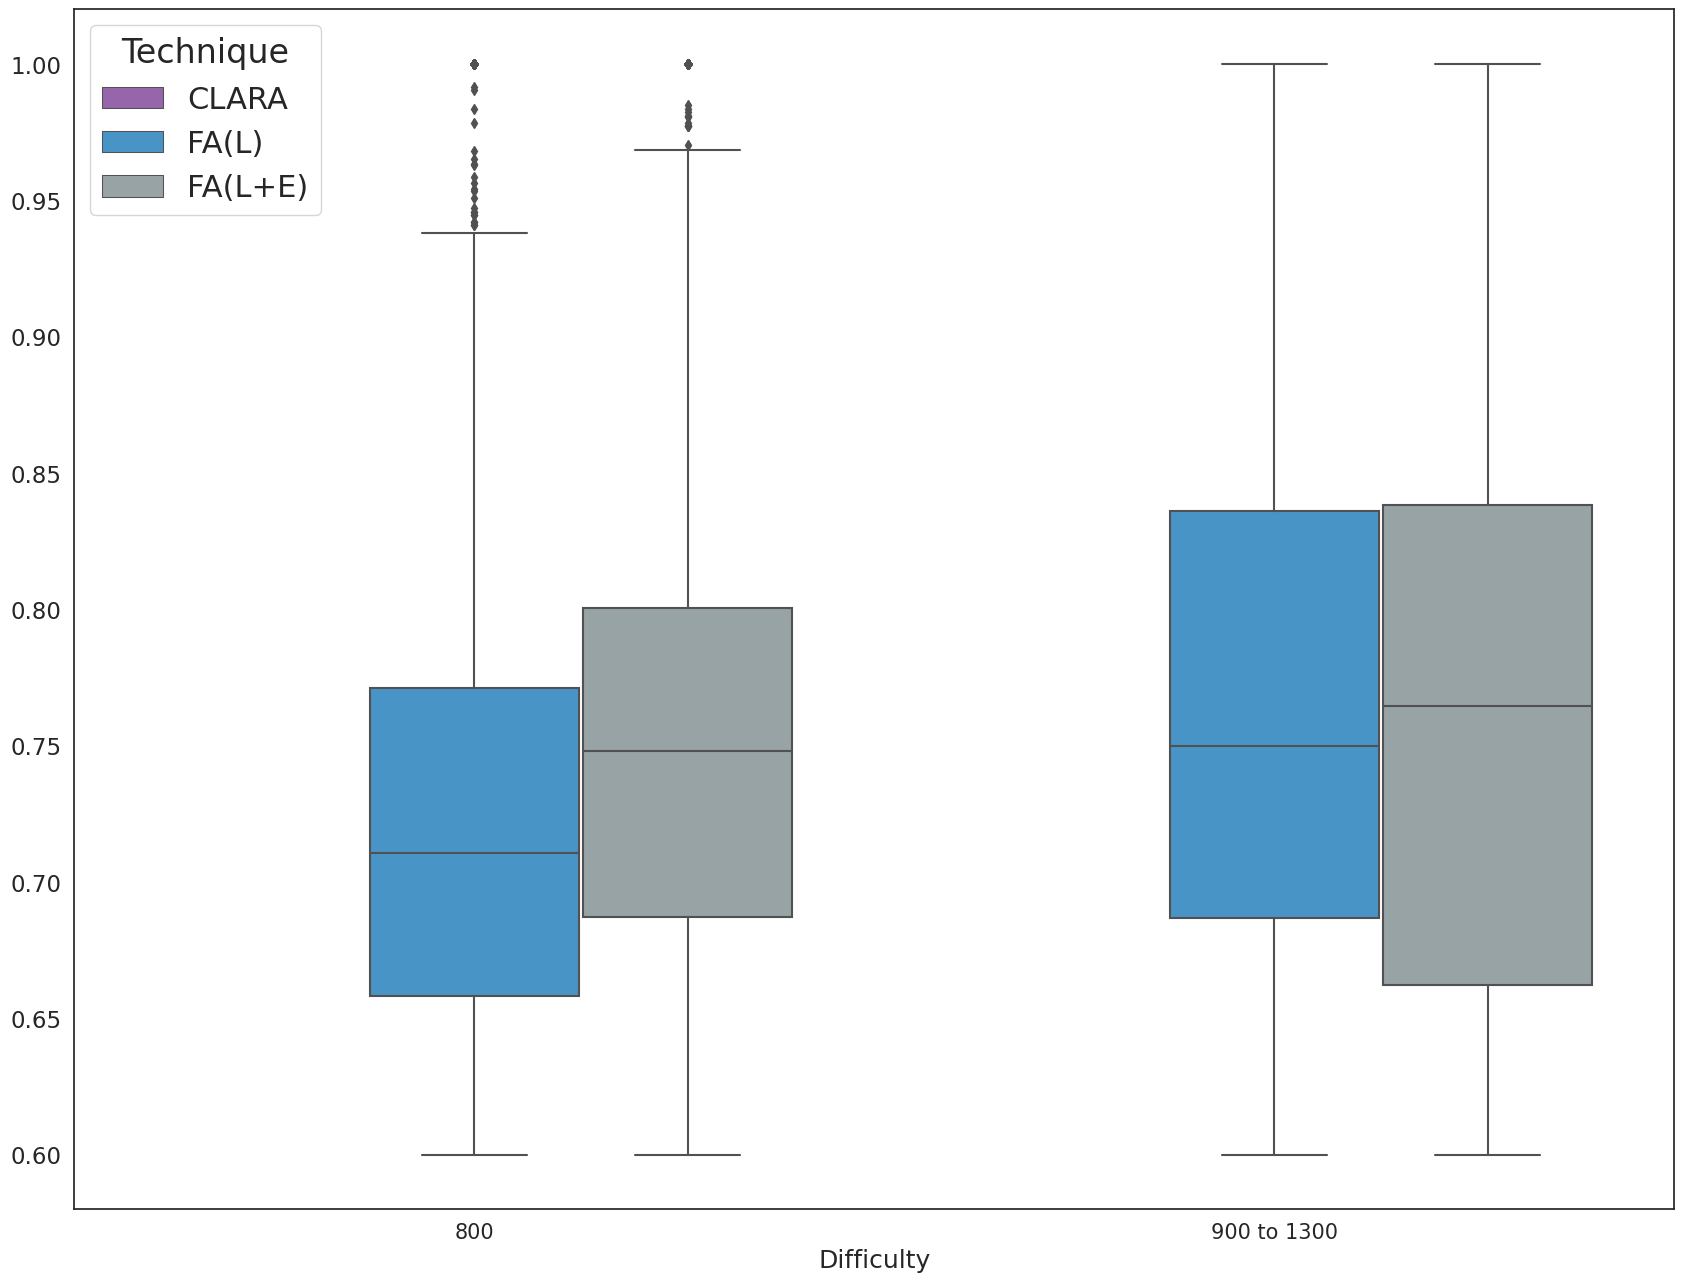

In [38]:
fig = plt.figure(figsize =(16, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=2)
sns.set_style("white")
# sns.barplot(x=repaired_tech_problem.index.get_level_values('diff_bin'),
#             hue=repaired_tech_problem.index.get_level_values('Technique'), 
#             y=repaired_tech_problem.values*100, ax=ax, palette=palette)
ax = sns.boxplot(
    data=filtered, 
    y="GM Score",
    x="diff_bin",
    orient="v",
    hue="Technique",
    palette=palette)
ax.set_ylabel("")
ax.set_xlabel("Difficulty")
ax.set_xticklabels(['800', '900 to 1300'], size = 15)
# ax.set_yticklabels([60,65,70,75,80,85,90,95,100])
plt.savefig('gm_by_diff.pdf', format="pdf", bbox_inches='tight')

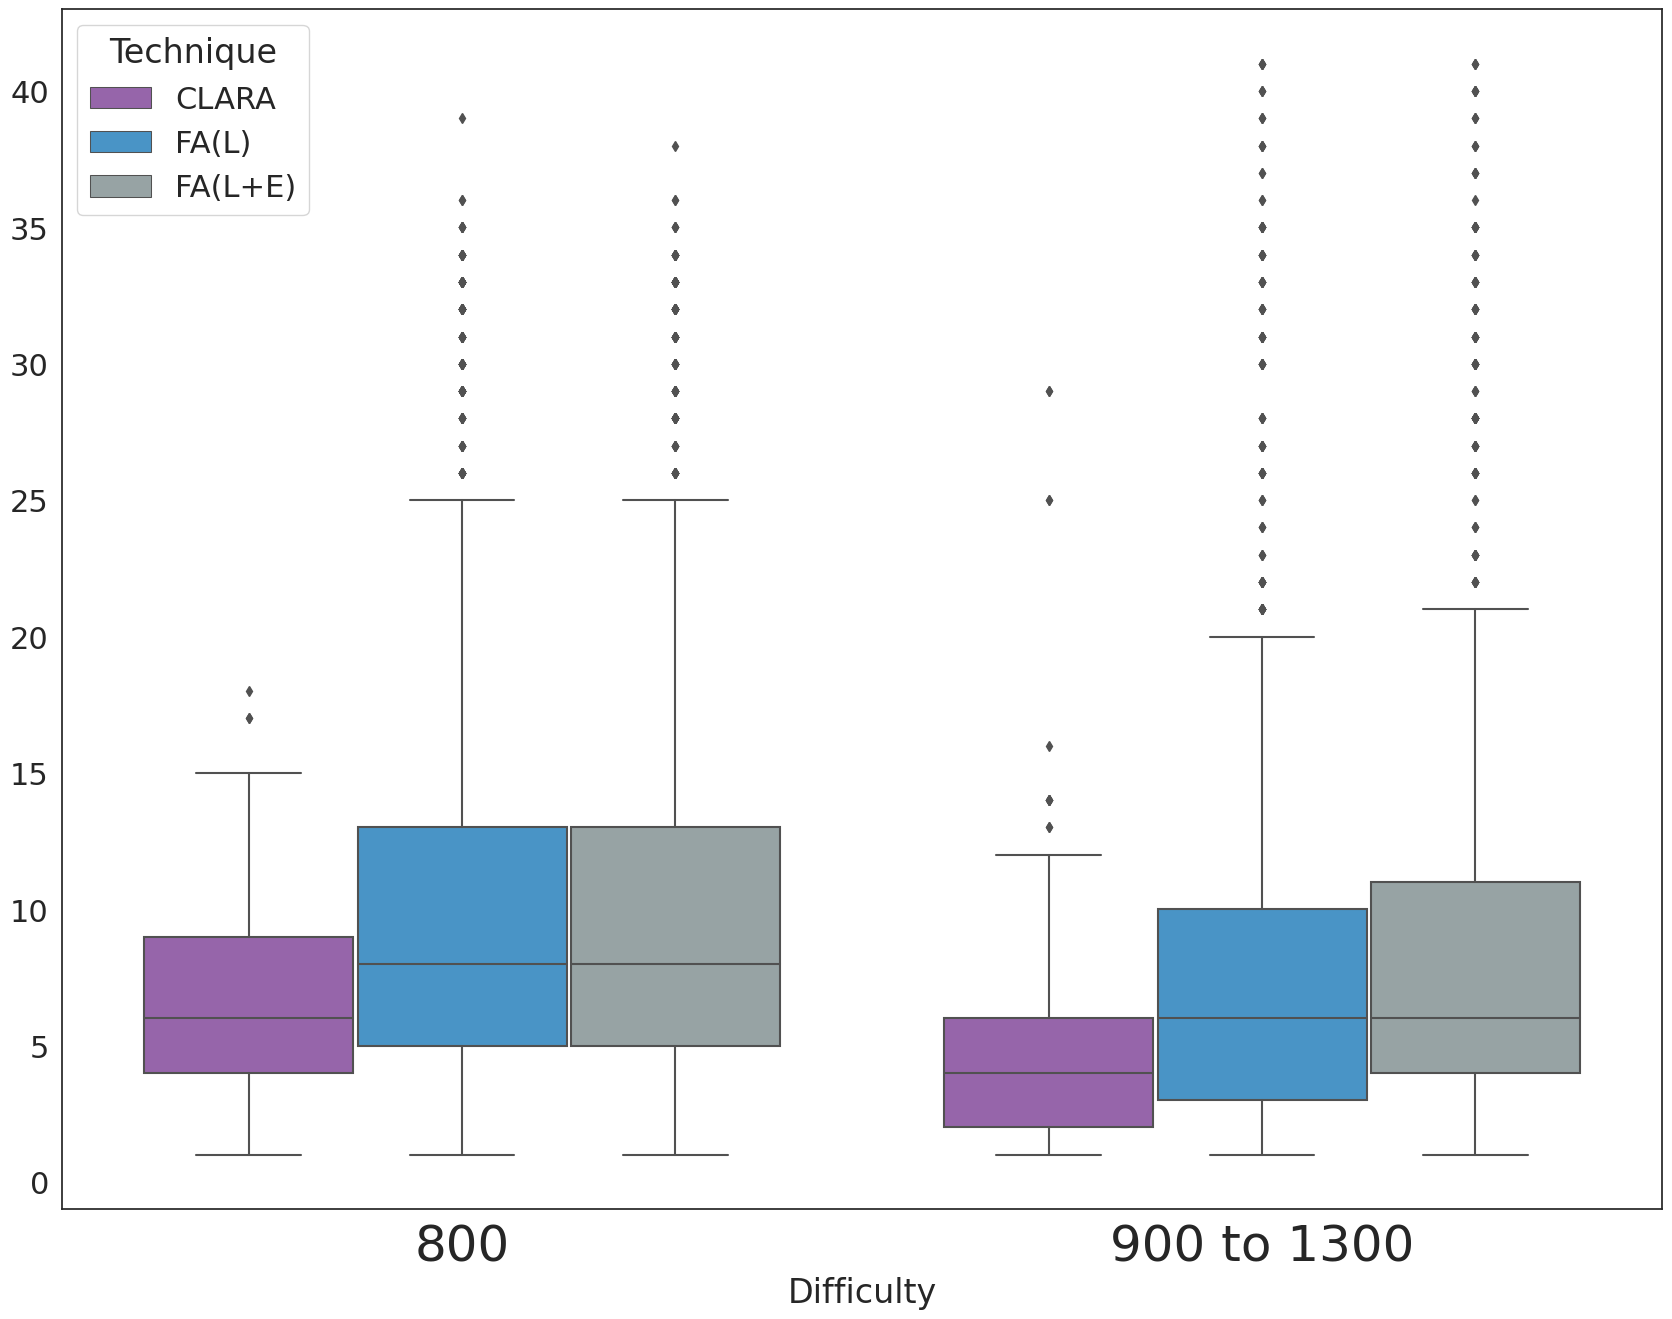

In [39]:
fig = plt.figure(figsize =(16, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=2)
sns.set_style("white")
# sns.barplot(x=repaired_tech_problem.index.get_level_values('diff_bin'),
#             hue=repaired_tech_problem.index.get_level_values('Technique'), 
#             y=repaired_tech_problem.values*100, ax=ax, palette=palette)
ax = sns.boxplot(
    data=filtered, 
    y="Repairs",
    x="diff_bin",
    orient="v", hue="Technique", palette=palette)
ax.set_ylabel("")
ax.set_xlabel("Difficulty")
ax.set_xticklabels(['800', '900 to 1300'], size = 36)
plt.savefig('repairs_by_diff.pdf', format="pdf", bbox_inches='tight')

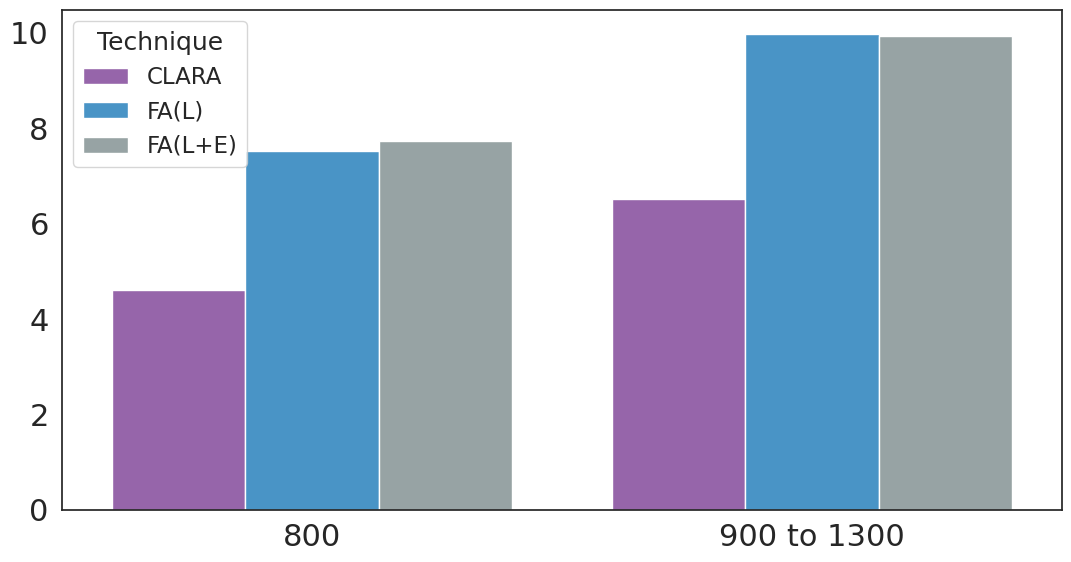

In [40]:
# filtered['exprs_bin'] = pd.cut(np.array(filtered['Correct Exprs']), bins=[0,10,20,30,40,50,60,70,80])
locs = filtered.groupby(['diff_bin', 'Technique'])['Repairs'].mean()
# y = np.array(filtered['Repairs'])
# z = np.array(filtered['Technique'])
fig = plt.figure(figsize =(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=locs.index.get_level_values('diff_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=palette)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticklabels(['800', '900 to 1300'])
plt.savefig('repairs_by_diff_bar.pdf', format="pdf", bbox_inches='tight')